In [3]:
# === Ant Actor Module Explorer — STREAMING CACHE (MULTI-RUN) ===
# Jupyter single cell; writes compact caches to disk and supports reload/plot mode.

import os
import glob
import pickle
import shutil
import gc
import traceback
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, BoundaryNorm
from scipy.cluster.hierarchy import linkage, optimal_leaf_ordering, fcluster, leaves_list
from scipy.spatial.distance import squareform
from scipy.optimize import linear_sum_assignment
from mpl_toolkits.axes_grid1 import make_axes_locatable
import ipywidgets as widgets
import math
import pandas as pd
from pathlib import Path

# =========================
# ========= CONFIG ========
# =========================

REPO_ROOT = Path.cwd().resolve()
if REPO_ROOT.name == "AnalysisScripts":
    REPO_ROOT = REPO_ROOT.parent

MODELS_DIR = (
    REPO_ROOT
    / "Checkpoints_States_selectedGraphs"
    / "Controls"
    / "WSJ_SpinOnly_relu_42_2026-02-01_03-49-02"
    / "models"
).resolve()

# -------------------------
# MODE SELECT
# -------------------------
CACHE_XLSX_PATH = ""  # set to cache dir to LOAD; leave "" to COMPUTE

# -------------------------
# MULTI-RUN COMPUTE CONTROL
# -------------------------
MULTI_RUN_MODE = True
RUN_PATHS = [str(MODELS_DIR)]  # can be a models dir or a parent folder to search under

RECOMPUTE_OVERWRITE = True
CONTINUE_ON_RUN_ERROR = True
PLOT_AFTER_EACH_RUN = False
RUN_DISCOVERY_MAX_DEPTH = 2

# =========================
# === MODEL SOURCE CONFIG ===
# =========================
MULTI_CYCLE_MODE = True
MODEL_DIR = str(MODELS_DIR)   # used when MULTI_RUN_MODE=False

MODEL_PATH_LIST = ""  # leave empty to glob MODEL_DIR/*_for_play.pth

# =========================
# === GLOBAL STATE POOL ===
# =========================
ALL_STATES_PATH = str(
    (REPO_ROOT / "Checkpoints_States_selectedGraphs" / "StatesConcat" / "ALL_states_concat.npy").resolve()
)

# ---- quick sanity prints ----
print("CWD          =", Path.cwd().resolve())
print("REPO_ROOT     =", REPO_ROOT)
print("MODELS_DIR    =", MODELS_DIR, "| exists:", MODELS_DIR.is_dir())
print("ALL_STATES    =", ALL_STATES_PATH, "| exists:", Path(ALL_STATES_PATH).is_file())


CWD          = /Users/adi/Desktop/EmergentRobotSelf/AnalysisScripts
REPO_ROOT     = /Users/adi/Desktop/EmergentRobotSelf
MODELS_DIR    = /Users/adi/Desktop/EmergentRobotSelf/Checkpoints_States_selectedGraphs/Controls/WSJ_SpinOnly_relu_42_2026-02-01_03-49-02/models | exists: True
ALL_STATES    = /Users/adi/Desktop/EmergentRobotSelf/Checkpoints_States_selectedGraphs/StatesConcat/ALL_states_concat.npy | exists: True


[BATCH] Will compute caches for these models dirs:
  01. /Users/adi/Desktop/EmergentRobotSelf/Checkpoints_States_selectedGraphs/Controls/WSJ_SpinOnly_relu_42_2026-02-01_03-49-02/models

[BATCH] Run 1/1

[RUN] WSJ_SpinOnly_relu_42_2026-02-01_03-49-02
      models_dir: /Users/adi/Desktop/EmergentRobotSelf/Checkpoints_States_selectedGraphs/Controls/WSJ_SpinOnly_relu_42_2026-02-01_03-49-02/models
      cache_root: /Users/adi/Desktop/EmergentRobotSelf/Checkpoints_States_selectedGraphs/Controls/WSJ_SpinOnly_relu_42_2026-02-01_03-49-02/models/_module_explorer_cache
      MULTI_CYCLE_MODE=True
      ALIVE_ONLY_CLUSTERING=True  ALIVE_ONLY_PLOTTING=True
      MODE: Persistence score (matched to two closest checkpoints)
      checkpoints: 120  behaviors: ['spin']
[CACHE] Plot-cache entries: 10 total.
[INFO] Obs dim inferred from: c001_b01_spin_plateau_2026-02-01_05-47-39_for_play.pth  -> 36
[STATES] Loading ALL states for obs_dim=36 ...
[STATES] loaded: (1375000, 36), sampled: (400000, 36)


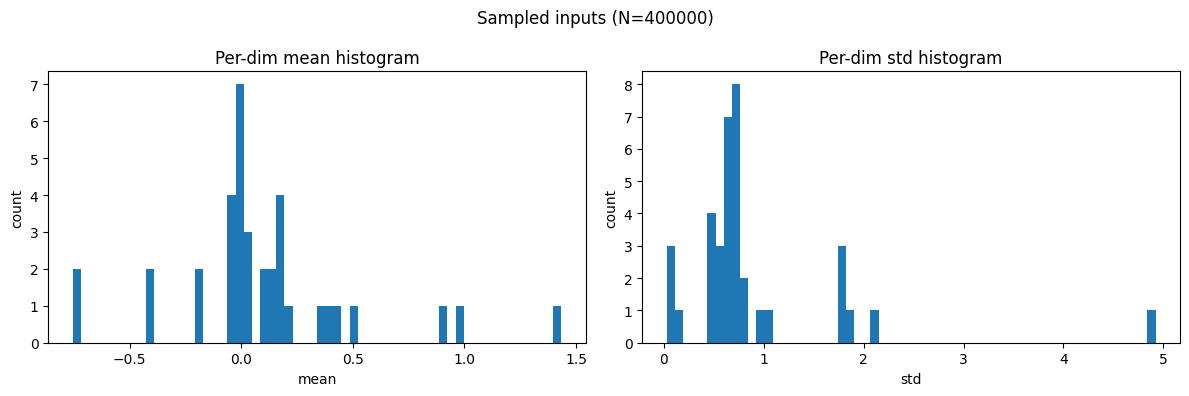

[STATES] input normalization disabled

--------------------------------------------------------------------------------
[SEQ] t=1/120  spin:c001_b01_spin_plateau_2026-02-01_05-47-39  refs=[c002_b01_spin_plateau_2026-02-01_06-33-57, c003_b01_spin_plateau_2026-02-01_07-43-43]

--------------------------------------------------------------------------------
[SEQ] t=2/120  spin:c002_b01_spin_plateau_2026-02-01_06-33-57  refs=[c001_b01_spin_plateau_2026-02-01_05-47-39, c003_b01_spin_plateau_2026-02-01_07-43-43]

--------------------------------------------------------------------------------
[SEQ] t=3/120  spin:c003_b01_spin_plateau_2026-02-01_07-43-43  refs=[c002_b01_spin_plateau_2026-02-01_06-33-57, c004_b01_spin_plateau_2026-02-01_08-27-15]

--------------------------------------------------------------------------------
[SEQ] t=4/120  spin:c004_b01_spin_plateau_2026-02-01_08-27-15  refs=[c003_b01_spin_plateau_2026-02-01_07-43-43, c005_b01_spin_plateau_2026-02-01_09-09-41]

-------------

/var/folders/w9/skzq08yx5191knmbcq8xd6_w0000gp/T/ipykernel_45743/3160504771.py:1052: RuntimeWarning: Mean of empty slice
  mean_act  = float(np.nanmean(act_by_neuron[mask_r]))        if np.any(mask_r) else np.nan
/var/folders/w9/skzq08yx5191knmbcq8xd6_w0000gp/T/ipykernel_45743/3160504771.py:1053: RuntimeWarning: Mean of empty slice
  mean_conn = float(np.nanmean(conn_by_neuron[mask_r]))       if np.any(mask_r) else np.nan
/var/folders/w9/skzq08yx5191knmbcq8xd6_w0000gp/T/ipykernel_45743/3160504771.py:1054: RuntimeWarning: Mean of empty slice
  mean_pers = float(np.nanmean(persistence_by_neuron[mask_r])) if np.any(mask_r) else np.nan



--------------------------------------------------------------------------------
[SEQ] t=33/120  spin:c034_b01_spin_plateau_2026-02-02_10-19-27  refs=[c033_b01_spin_plateau_2026-02-02_09-36-50, c035_b01_spin_plateau_2026-02-02_11-01-45]

--------------------------------------------------------------------------------
[SEQ] t=34/120  spin:c035_b01_spin_plateau_2026-02-02_11-01-45  refs=[c034_b01_spin_plateau_2026-02-02_10-19-27, c036_b01_spin_plateau_2026-02-02_11-45-01]

--------------------------------------------------------------------------------
[SEQ] t=35/120  spin:c036_b01_spin_plateau_2026-02-02_11-45-01  refs=[c035_b01_spin_plateau_2026-02-02_11-01-45, c037_b01_spin_plateau_2026-02-02_12-28-30]

--------------------------------------------------------------------------------
[SEQ] t=36/120  spin:c037_b01_spin_plateau_2026-02-02_12-28-30  refs=[c036_b01_spin_plateau_2026-02-02_11-45-01, c038_b01_spin_plateau_2026-02-02_13-11-12]

-----------------------------------------------

In [4]:


RECOMPUTE_OVERWRITE = True
CONTINUE_ON_RUN_ERROR = True
PLOT_AFTER_EACH_RUN = False
RUN_DISCOVERY_MAX_DEPTH = 2

# -------------------------
# CACHE OUTPUT CONTROL
# -------------------------
PLOT_CACHE_N_CYCLES = 10
TOPK_CLUSTERS_SUMMARY = 10

# ---- Variant selector ----
# 1: signed R, natural order (clustering uses |R|)
# 2: |R| heatmaps, natural order (clustering uses |R|)
# 3: signed R, clusters ordered largest -> smallest (clustering uses |R|)
# 4: |R| heatmaps, clusters ordered largest -> smallest (clustering uses |R|)
# 5: signed R, clusters ordered largest -> smallest + SIGNED clustering distance
VERSION = 3

# --- Robust-loading / skip behavior ---
ALLOW_UNSAFE_TORCH_LOAD = True
SKIP_BAD_CYCLES = True
MIN_CKPT_BYTES = 0

# =========================
# === MODEL SOURCE CONFIG ===
# =========================

# MULTI_CYCLE_MODE=True means "discover checkpoints under MODEL_DIR / MODEL_PATH_LIST".
MULTI_CYCLE_MODE = True

# If MULTI_CYCLE_MODE=True, pass a directory containing "*_for_play.pth"
MODEL_DIR = r"/Users/adi/Desktop/WSJ_att69_Control_11_2026-02-03_15-29-13/models"

MODEL_PATH_LIST = """
"""

# If MULTI_CYCLE_MODE=False, provide explicit sequences. (Typically one behavior sequence.)
SINGLE_BEHAVIOR_MODEL_PATHS = {
    # "walk": [
    #     "/path/to/c001_b01_walk_..._for_play.pth",
    #     "/path/to/c002_b01_walk_..._for_play.pth",
    # ],
}
SINGLE_SEQUENCE_ID = "single_seq"

# =========================
# === GLOBAL STATE POOL ===
# =========================

N_ALL_STATES    = 400_000

PLOT_INPUTS_SUMMARY = True

ANALYZE_NORM_INPUTS = True
INPUT_NORM_MODE = "none"   # "zscore" or "none"

# --- Layers to analyze (hidden layers) ---
LAYER_INDICES = [0, 1]

SEED       = 0
EPS        = 1e-8
MIN_STD    = 1e-5

KEEP_DEAD  = True
ACTIVATION = "relu"  # {"elu","relu","tanh"}

# alive-only control
ALIVE_ONLY_CLUSTERING = True
ALIVE_ONLY_PLOTTING   = True

CMAP               = "RdBu_r"
VMIN, VCENTER, VMAX = -1.0, 0.0, 1.0

K_MIN, K_MAX  = 2, 10
ALPHA_SMALL_K = 0.05

DEVICE = "cpu"

# =========================
# ======== HELPERS ========
# =========================

def _seed_everything(seed: int):
    import random
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def _torch_load_compat(path: str):
    if MIN_CKPT_BYTES and os.path.exists(path):
        try:
            sz = os.path.getsize(path)
            if sz < MIN_CKPT_BYTES:
                raise RuntimeError(f"Checkpoint too small ({sz} bytes) < MIN_CKPT_BYTES={MIN_CKPT_BYTES}")
        except OSError:
            pass

    try:
        return torch.load(path, map_location="cpu", weights_only=True)
    except TypeError:
        return torch.load(path, map_location="cpu")
    except (pickle.UnpicklingError, RuntimeError, EOFError, ValueError):
        if not ALLOW_UNSAFE_TORCH_LOAD:
            raise
        try:
            return torch.load(path, map_location="cpu", weights_only=False)
        except TypeError:
            return torch.load(path, map_location="cpu")

def _load_rlg_forplay_state_dict(path: str) -> dict:
    payload = _torch_load_compat(path)
    if isinstance(payload, dict) and "model" in payload and isinstance(payload["model"], dict):
        sd = {}
        for k, v in payload["model"].items():
            sd[k] = v.detach().cpu().clone() if torch.is_tensor(v) else v
        return sd
    raise ValueError(f"[ckpt] {path} missing 'model' dict (for-play).")

def _try_load_sd(path: str):
    try:
        sd = _load_rlg_forplay_state_dict(path)
        return sd, None
    except Exception as e:
        return None, f"{type(e).__name__}: {e}"

def _discover_actor_mlp_layers(state_dict: dict):
    candidates = []
    for k in state_dict.keys():
        if k.endswith(".weight") and ("actor_mlp" in k or ".actor." in k or "actor_net" in k or "actor.trunk" in k):
            parts = k.split(".")
            try:
                idx = int(parts[-2])
                bias_key = k[:-6] + "bias"
                if bias_key in state_dict:
                    candidates.append((idx, k, bias_key))
            except Exception:
                candidates.append((10**6, k, k[:-6] + "bias"))
    candidates.sort(key=lambda t: (t[0], t[1]))
    return candidates

def _first_linear_in(actor_layers, sd):
    if not actor_layers:
        raise RuntimeError("No actor MLP layers found.")
    _, wkey, _ = actor_layers[0]
    W = sd[wkey]
    if isinstance(W, torch.Tensor):
        W = W.detach().cpu().numpy()
    if W.ndim != 2:
        raise RuntimeError(f"Unexpected weight shape for {wkey}: {tuple(W.shape)}")
    return W.shape[1], W.shape[0]  # in_dim, out_dim

def _activation(x: np.ndarray, name: str) -> np.ndarray:
    if name == "elu":
        y = x.copy()
        neg = x <= 0
        y[neg] = np.expm1(x[neg])
        return y
    if name == "relu":
        return np.maximum(0.0, x)
    if name == "tanh":
        return np.tanh(x)
    raise ValueError(f"Unsupported ACTIVATION '{name}'")

def _zscore_cols(X: np.ndarray, eps: float = 1e-8) -> np.ndarray:
    if X.size == 0:
        return X.astype(np.float32, copy=False)
    mu = X.mean(axis=0, keepdims=True)
    sd = X.std(axis=0, keepdims=True)
    sd = np.where(sd < 1e-12, 1.0, sd)
    return ((X - mu) / (sd + eps)).astype(np.float32, copy=False)

def _dead_alive_indices(acts_post: np.ndarray, min_std: float):
    if acts_post.size == 0:
        return np.array([], dtype=int), np.array([], dtype=int)
    sd = acts_post.std(axis=0)
    dead_mask = sd <= min_std
    dead_idx = np.where(dead_mask)[0].astype(int)
    alive_idx = np.where(~dead_mask)[0].astype(int)
    return dead_idx, alive_idx

def corr_matrix(X):
    """
    Cosine-similarity matrix between columns of X.
    X: (T, N) activations. Returns (N, N), diag=1.
    """
    X = np.asarray(X, dtype=np.float32)
    if X.ndim != 2:
        raise ValueError("corr_matrix expects 2D array (T, N)")
    n = X.shape[1]
    if n == 0:
        return np.zeros((0, 0), np.float32)
    if n == 1:
        return np.ones((1, 1), np.float32)

    norms = np.linalg.norm(X, axis=0, keepdims=True).astype(np.float64)
    norms = np.where(norms < 1e-12, 1.0, norms)
    Xn = (X.astype(np.float64, copy=False) / norms)

    S = (Xn.T @ Xn)
    S = np.nan_to_num(S, nan=0.0, posinf=0.0, neginf=0.0)
    S = np.clip(S, -1.0, 1.0)

    np.fill_diagonal(S, 1.0)
    return S.astype(np.float32, copy=False)

def _within_between_stats(M, labels):
    if M.size == 0 or labels.size == 0:
        return dict(within=np.nan, between=np.nan, delta=np.nan)
    same = (labels[:, None] == labels[None, :])
    np.fill_diagonal(same, False)
    within = M[same]
    between = M[~same]
    w = float(within.mean()) if within.size else np.nan
    b = float(between.mean()) if between.size else np.nan
    return dict(within=w, between=b, delta=(w - b) if np.isfinite(w) and np.isfinite(b) else np.nan)

def _modularity_Q_pos(R_abs, labels):
    A = np.clip(R_abs, 0.0, None).astype(np.float64)
    np.fill_diagonal(A, 0.0)
    m = A.sum() / 2.0
    if m <= 0:
        return np.nan
    k = A.sum(axis=1)
    Q = 0.0
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if labels[i] == labels[j]:
                Q += A[i, j] - (k[i]*k[j] / (2.0*m))
    return float(Q / (2.0*m))

def _norm01(a):
    a = np.array(a, dtype=np.float64)
    if np.all(np.isnan(a)):
        return np.zeros_like(a)
    lo, hi = np.nanmin(a), np.nanmax(a)
    return np.zeros_like(a) if hi - lo < 1e-12 else (a - lo) / (hi - lo)

def _cluster_order_and_labels_signed(R_signed, K):
    n = int(R_signed.shape[0])
    if n == 0:
        return np.array([], int), np.array([], int)
    if n < 3:
        order = np.arange(n, dtype=int)
        labels = np.ones(n, dtype=int)
        return order, labels

    R_signed = np.asarray(R_signed, dtype=np.float32)
    R_signed = np.clip(R_signed, -1.0, 1.0)

    D = 0.5 * (1.0 - R_signed)
    np.fill_diagonal(D, 0.0)
    D = np.maximum(D, 0.0)

    y = squareform(D, checks=False)
    Z = linkage(y, method="average")
    Z = optimal_leaf_ordering(Z, y)
    order = leaves_list(Z)
    labels = fcluster(Z, t=K, criterion="maxclust")
    return order, labels

def _cluster_order_and_labels_abs(R_abs, K):
    n = int(R_abs.shape[0])
    if n == 0:
        return np.array([], int), np.array([], int)
    if n < 3:
        order = np.arange(n, dtype=int)
        labels = np.ones(n, dtype=int)
        return order, labels

    R_abs = np.asarray(R_abs, dtype=np.float32)
    R_abs = np.clip(R_abs, 0.0, 1.0)

    D = 1.0 - R_abs
    np.fill_diagonal(D, 0.0)
    D = np.maximum(D, 0.0)

    y = squareform(D, checks=False)
    Z = linkage(y, method="average")
    Z = optimal_leaf_ordering(Z, y)
    order = leaves_list(Z)
    labels = fcluster(Z, t=K, criterion="maxclust")
    return order, labels

def choose_K_and_order_abs(R_abs, k_min=2, k_max=10, alpha_small_k=0.05):
    n = int(R_abs.shape[0])
    if n == 0:
        return 2, np.array([], int), np.array([], int)
    if n < 3:
        order = np.arange(n, dtype=int)
        labels = np.ones(n, dtype=int)
        return 1, order, labels

    Ks = list(range(max(2, k_min), max(k_min, k_max) + 1))
    deltas, Qs, orders, labels_store = [], [], {}, {}
    for K in Ks:
        order, labels = _cluster_order_and_labels_abs(R_abs, K)
        orders[K] = order
        labels_store[K] = labels
        st = _within_between_stats(R_abs, labels)
        deltas.append(st["delta"])
        Qs.append(_modularity_Q_pos(R_abs, labels))
    dN = _norm01(deltas)
    qN = _norm01(Qs)
    kN = (np.array(Ks) - min(Ks)) / (max(Ks) - min(Ks) + 1e-12)
    score = 0.6*dN + 0.4*qN - alpha_small_k*kN
    K_best = Ks[int(np.nanargmax(score))]
    return K_best, orders[K_best], labels_store[K_best]

def choose_K_and_order_signed(R_signed, k_min=2, k_max=10, alpha_small_k=0.05):
    n = int(R_signed.shape[0])
    if n == 0:
        return 2, np.array([], int), np.array([], int)
    if n < 3:
        order = np.arange(n, dtype=int)
        labels = np.ones(n, dtype=int)
        return 1, order, labels

    Ks = list(range(max(2, k_min), max(k_min, k_max) + 1))
    deltas, Qs, orders, labels_store = [], [], {}, {}
    for K in Ks:
        order, labels = _cluster_order_and_labels_signed(R_signed, K)
        orders[K] = order
        labels_store[K] = labels
        st = _within_between_stats(R_signed, labels)
        deltas.append(st["delta"])
        Qs.append(_modularity_Q_pos(np.clip(R_signed, 0.0, None), labels))
    dN = _norm01(deltas)
    qN = _norm01(Qs)
    kN = (np.array(Ks) - min(Ks)) / (max(Ks) - min(Ks) + 1e-12)
    score = 0.6*dN + 0.4*qN - alpha_small_k*kN
    K_best = Ks[int(np.nanargmax(score))]
    return K_best, orders[K_best], labels_store[K_best]

def _cluster_bounds(labels, order):
    lr = labels[order]
    return [i - 0.5 for i in range(1, len(lr)) if lr[i] != lr[i-1]]

def hungarian_match_cosine(A, B, eps=1e-8):
    A = np.asarray(A, dtype=np.float32)
    B = np.asarray(B, dtype=np.float32)

    if A.size == 0 or B.size == 0:
        sim = np.zeros((A.shape[1] if A.ndim == 2 else 0, B.shape[1] if B.ndim == 2 else 0), dtype=np.float32)
        return sim, np.array([], dtype=int), np.array([], dtype=int), np.array([], dtype=float)

    nA = np.linalg.norm(A, axis=0, keepdims=True)
    nB = np.linalg.norm(B, axis=0, keepdims=True)
    nA[nA < eps] = 1.0
    nB[nB < eps] = 1.0

    sim = (A.T @ B) / (nA.T @ nB)
    sim = np.nan_to_num(sim)
    sim = np.clip(sim, -1.0, 1.0)

    i_idx, j_idx = linear_sum_assignment(-sim)
    matched_vals = sim[i_idx, j_idx] if i_idx.size else np.array([], dtype=float)
    return sim, i_idx, j_idx, matched_vals

def _actor_hidden_forward_numpy(X, actor_layers, sd, activation_name):
    outs = []
    h = X
    for _, wkey, bkey in actor_layers:
        W = sd[wkey]
        if isinstance(W, torch.Tensor):
            W = W.detach().cpu().numpy()
        b = sd[bkey]
        if isinstance(b, torch.Tensor):
            b = b.detach().cpu().numpy()
        h = h @ W.T + b[None, :]
        h = _activation(h, activation_name)
        outs.append(h.astype(np.float32, copy=False))
    return outs

def get_layer_output_batch_from_ckpt(sd, inputs: torch.Tensor, layer_idx: int, actor_layers, activation_name):
    X = inputs.detach().cpu().numpy().astype(np.float32, copy=False)
    outs = _actor_hidden_forward_numpy(X, actor_layers, sd, activation_name)
    if layer_idx < 0 or layer_idx >= len(outs):
        raise IndexError(f"layer_idx={layer_idx} out of range (0..{len(outs)-1})")
    return outs[layer_idx]

def _safe_corr(a, b, eps: float = 1e-8):
    """
    Absolute cosine similarity between 1D vectors a and b.
    """
    a = np.asarray(a, dtype=np.float32).ravel()
    b = np.asarray(b, dtype=np.float32).ravel()
    if a.size != b.size or a.size == 0:
        return 0.0

    na = float(np.linalg.norm(a))
    nb = float(np.linalg.norm(b))
    if na < eps or nb < eps:
        return 0.0

    c = float((a.astype(np.float64) @ b.astype(np.float64)) / (na * nb))
    if not np.isfinite(c):
        return 0.0
    c = max(-1.0, min(1.0, c))
    return float(abs(c))

def _order_by_cluster_size(labels, base_order=None):
    labels = np.asarray(labels)
    n = labels.size
    if n == 0:
        return np.arange(0, dtype=int)
    if base_order is None:
        base_order = np.arange(n, dtype=int)
    base_order = np.asarray(base_order)
    unique_cids = np.unique(labels)
    sizes = [int(np.sum(labels == cid)) for cid in unique_cids]
    sorted_cids = [cid for cid, _ in sorted(zip(unique_cids, sizes), key=lambda t: -t[1])]
    new_order_list = []
    labels_in_base = labels[base_order]
    for cid in sorted_cids:
        mask = (labels_in_base == cid)
        new_order_list.append(base_order[mask])
    new_order = np.concatenate(new_order_list) if new_order_list else np.arange(n, dtype=int)
    return new_order

def _relabel_clusters_by_size(labels):
    labels = np.asarray(labels)
    if labels.size == 0:
        return labels.astype(int)
    unique_cids, counts = np.unique(labels, return_counts=True)
    order = np.argsort(-counts)
    sorted_cids = unique_cids[order]
    cid_to_rank = {cid: rank + 1 for rank, cid in enumerate(sorted_cids)}
    new_labels = np.array([cid_to_rank[c] for c in labels], dtype=int)
    return new_labels

def _evenly_spaced_indices(n, k):
    if k <= 0:
        return []
    if n <= k:
        return list(range(n))
    idxs = np.linspace(0, n - 1, k)
    idxs = np.unique(np.round(idxs).astype(int)).tolist()
    if len(idxs) < k:
        for i in range(n):
            if i not in idxs:
                idxs.append(i)
            if len(idxs) >= k:
                break
        idxs = sorted(idxs)[:k]
    return idxs

def _plot_inputs_summary(X: np.ndarray, title: str = "Sampled inputs"):
    mu = X.mean(axis=0)
    sd = X.std(axis=0)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].hist(mu, bins=60)
    axes[0].set_title("Per-dim mean histogram")
    axes[0].set_xlabel("mean")
    axes[0].set_ylabel("count")

    axes[1].hist(sd, bins=60)
    axes[1].set_title("Per-dim std histogram")
    axes[1].set_xlabel("std")
    axes[1].set_ylabel("count")

    fig.suptitle(title, fontsize=12)
    plt.tight_layout()
    plt.show()

# =========================
# === MULTI-RUN IO ===
# =========================

def _looks_like_models_dir(d: str) -> bool:
    if not os.path.isdir(d):
        return False
    return len(glob.glob(os.path.join(d, "*_for_play.pth"))) > 0

def _resolve_models_dir(p: str) -> str | None:
    if not p:
        return None
    p = os.path.expanduser(os.path.expandvars(str(p).strip()))
    if not p:
        return None

    if os.path.isfile(p):
        d = os.path.dirname(p)
        if os.path.basename(d) == "models":
            return d
        if _looks_like_models_dir(d):
            return d
        return None

    if not os.path.isdir(p):
        return None

    base = os.path.basename(p)

    if base == "_module_explorer_cache":
        md = os.path.dirname(p)
        if os.path.basename(md) == "models":
            return md

    if base == "models":
        return p

    md = os.path.join(p, "models")
    if os.path.isdir(md):
        return md

    md2 = os.path.join(p, "organized", "models")
    if os.path.isdir(md2):
        return md2

    return None

def _discover_models_dirs_under_parent(parent: str, max_depth: int = 2):
    parent = os.path.expanduser(os.path.expandvars(str(parent).strip()))
    if not os.path.isdir(parent):
        return []

    found = set()
    parent_depth = parent.rstrip(os.sep).count(os.sep)

    for root, dirs, files in os.walk(parent):
        depth = root.count(os.sep) - parent_depth
        if depth > max_depth:
            dirs[:] = []
            continue

        if os.path.basename(root) == "models":
            found.add(root)

        if "models" in dirs:
            found.add(os.path.join(root, "models"))

        if "organized" in dirs:
            cand = os.path.join(root, "organized", "models")
            if os.path.isdir(cand):
                found.add(cand)

    out = []
    for d in sorted(found):
        if _looks_like_models_dir(d):
            out.append(d)
    return out

def _expand_run_inputs(run_paths, max_depth=2):
    model_dirs = []
    for p in run_paths:
        p = os.path.expanduser(os.path.expandvars(str(p).strip()))
        if not p:
            continue
        md = _resolve_models_dir(p)
        if md is not None and _looks_like_models_dir(md):
            model_dirs.append(md)
            continue
        if os.path.isdir(p):
            model_dirs.extend(_discover_models_dirs_under_parent(p, max_depth=max_depth))

    model_dirs = sorted(set(model_dirs))
    return model_dirs

def _clear_existing_cache(cache_root: str):
    if not os.path.isdir(cache_root):
        return

    for fn in [
        "phase_summary.csv",
        "plot_cache_index.csv",
        "module_explorer_cache.h5",
        "module_explorer_cache.xlsx",
    ]:
        fp = os.path.join(cache_root, fn)
        if os.path.exists(fp):
            try:
                os.remove(fp)
            except Exception:
                pass

    pc = os.path.join(cache_root, "plot_cache_npz")
    if os.path.isdir(pc):
        try:
            shutil.rmtree(pc)
        except Exception:
            pass

# =========================
# === GLOBAL STATES ===
# =========================

_STATES_CACHE = {}  # obs_dim -> dict(ref_inputs, combined_states)

def _get_ref_inputs_for_obs_dim(obs_dim: int):
    global _STATES_CACHE
    if obs_dim in _STATES_CACHE:
        return _STATES_CACHE[obs_dim]["ref_inputs"], _STATES_CACHE[obs_dim]["combined_states"]

    if not os.path.exists(ALL_STATES_PATH):
        raise FileNotFoundError(f"[states] missing: {ALL_STATES_PATH}")

    print(f"[STATES] Loading ALL states for obs_dim={obs_dim} ...")
    all_states = np.load(ALL_STATES_PATH)
    if all_states.ndim != 2 or all_states.shape[1] != obs_dim:
        raise ValueError(f"[states] {ALL_STATES_PATH} has shape {all_states.shape}, expected (*,{obs_dim})")

    n_avail = all_states.shape[0]
    if n_avail >= N_ALL_STATES:
        idx = np.random.choice(n_avail, size=N_ALL_STATES, replace=False)
        combined_states = all_states[idx].astype(np.float32, copy=False)
    else:
        idx = np.random.choice(n_avail, size=N_ALL_STATES, replace=True)
        combined_states = all_states[idx].astype(np.float32, copy=False)

    print(f"[STATES] loaded: {all_states.shape}, sampled: {combined_states.shape}")

    if PLOT_INPUTS_SUMMARY:
        _plot_inputs_summary(combined_states, title=f"Sampled inputs (N={N_ALL_STATES})")

    if ANALYZE_NORM_INPUTS and INPUT_NORM_MODE == "zscore":
        mu_in = combined_states.mean(axis=0, keepdims=True)
        sd_in = combined_states.std(axis=0, keepdims=True)
        combined_states = (combined_states - mu_in) / (sd_in + 1e-8)
        print("[STATES] applied input z-score normalization")
    else:
        print("[STATES] input normalization disabled")

    ref_inputs = torch.as_tensor(combined_states, dtype=torch.float32, device=DEVICE)

    _STATES_CACHE[obs_dim] = {
        "ref_inputs": ref_inputs,
        "combined_states": combined_states,
    }
    return ref_inputs, combined_states

# =========================
# === DISCOVERY (GLOBAL ORDER) ===
# =========================

def _parse_ckpt_meta_from_filename(path: str):
    """
    Expected patterns:
      c038_b01_walk_..._for_play.pth
      c003_b02_spin_..._for_play.pth
      c003_b03_jump_..._for_play.pth

    Returns dict with:
      cycle_id, cycle_num, b_id, b_num, behavior, ckpt_id
    or None if unrecognized.
    """
    base = os.path.basename(path)
    if not base.endswith("_for_play.pth"):
        return None
    parts = base.split("_")
    if len(parts) < 3:
        return None

    cycle_id = parts[0]
    b_id = parts[1].lower()
    behavior = parts[2].lower()

    if behavior not in ("walk", "jump", "spin"):
        return None
    if not b_id.startswith("b"):
        return None

    # numeric sort keys
    cycle_digits = "".join(ch for ch in cycle_id if ch.isdigit())
    b_digits = "".join(ch for ch in b_id if ch.isdigit())
    cycle_num = int(cycle_digits) if cycle_digits else 0
    b_num = int(b_digits) if b_digits else 0

    ckpt_id = base[:-len("_for_play.pth")]

    return {
        "cycle_id": cycle_id,
        "cycle_num": cycle_num,
        "b_id": b_id,
        "b_num": b_num,
        "behavior": behavior,
        "ckpt_id": ckpt_id,
    }

def _discover_forplay_models_global(model_dir: str | None, model_path_list: str | None):
    """
    Returns:
      seq_all: list of dicts with keys:
        ckpt_id, cycle_id, behavior, path, global_idx, beh_seq_idx
      all_paths: sorted unique list
    """
    paths = []
    if model_path_list is not None and str(model_path_list).strip():
        for token in str(model_path_list).split():
            token = token.strip()
            if token.endswith("_for_play.pth"):
                paths.append(token)
    if model_dir is not None and str(model_dir).strip():
        pattern = os.path.join(str(model_dir), "*_for_play.pth")
        paths.extend(glob.glob(pattern))
    paths = sorted(set(paths))
    if not paths:
        raise RuntimeError("No *_for_play.pth models found from MODEL_DIR / MODEL_PATH_LIST.")

    items = []
    for p in paths:
        meta = _parse_ckpt_meta_from_filename(p)
        if meta is None:
            print(f"[warn] Skipping unrecognized filename: {os.path.basename(p)}")
            continue
        items.append({
            **meta,
            "path": p,
        })

    if not items:
        raise RuntimeError("No recognized (walk/jump/spin) checkpoints found among *_for_play.pth files.")

    items.sort(key=lambda d: (d["cycle_num"], d["cycle_id"], d["b_num"], d["b_id"], os.path.basename(d["path"])))

    # assign indices
    beh_counts = {}
    seq_all = []
    for gi, d in enumerate(items):
        beh = d["behavior"]
        beh_counts[beh] = beh_counts.get(beh, 0) + 1
        seq_all.append({
            "ckpt_id": d["ckpt_id"],
            "cycle_id": d["cycle_id"],
            "behavior": beh,
            "path": d["path"],
            "global_idx": int(gi),
            "beh_seq_idx": int(beh_counts[beh] - 1),
        })

    return seq_all, paths

def _infer_obs_dim_from_any_path(path_list):
    for p in path_list:
        if not os.path.exists(p):
            continue
        sd, err = _try_load_sd(p)
        if sd is None:
            continue
        layers = _discover_actor_mlp_layers(sd)
        if not layers:
            continue
        obs_dim, _ = _first_linear_in(layers, sd)
        return obs_dim, p
    raise RuntimeError("Could not infer obs_dim: no loadable model found.")

# =========================
# === SINGLE-SEQUENCE MODE ===
# =========================

def _sequence_from_single_behavior_paths(single_paths_by_beh: dict, seq_id_prefix: str = "single"):
    """
    Flattens provided paths into one global sequence (typically one behavior).
    If multiple behaviors are provided, concatenates in walk/spin/jump order.
    """
    order = ["walk", "spin", "jump"]
    flat = []
    for beh in order:
        if beh not in single_paths_by_beh:
            continue
        lst = single_paths_by_beh[beh]
        if not isinstance(lst, (list, tuple)) or len(lst) == 0:
            continue
        for i, p in enumerate(lst):
            p = os.path.expanduser(os.path.expandvars(str(p)))
            if not os.path.exists(p):
                raise FileNotFoundError(f"[single:{beh}] missing: {p}")
            flat.append({
                "ckpt_id": f"{seq_id_prefix}{i:04d}_{beh}",
                "cycle_id": f"{seq_id_prefix}{i:04d}",
                "behavior": beh,
                "path": p,
                "global_idx": len(flat),
                "beh_seq_idx": i,
            })
    if not flat:
        raise RuntimeError("SINGLE_BEHAVIOR_MODEL_PATHS is empty / invalid.")
    return flat

# =========================
# === CORE COMPUTE ===
# =========================

def _choose_reference_indices(n_total: int, t: int):
    """
    Returns up to two indices (excluding t) that are closest in sequence order.
    """
    if n_total <= 1:
        return []
    refs = []
    if t - 1 >= 0:
        refs.append(t - 1)
    if t + 1 < n_total:
        refs.append(t + 1)
    if len(refs) < 2:
        if t == 0 and t + 2 < n_total:
            refs.append(t + 2)
        if t == n_total - 1 and t - 2 >= 0:
            refs.append(t - 2)
    # sort by distance then index
    refs = sorted(set(refs), key=lambda j: (abs(j - t), j))
    return refs[:2]

def compute_cache_for_one_models_dir(model_dir: str, overwrite_cache: bool = True):
    """
    Computes module structure per checkpoint, and persistence scores by matching each checkpoint
    to up to two closest checkpoints in the global sequence order.
    """
    if MULTI_CYCLE_MODE:
        if not str(model_dir).strip():
            raise RuntimeError("MODEL_DIR is empty (needed when MULTI_CYCLE_MODE=True).")
        model_dir = os.path.expanduser(os.path.expandvars(model_dir))
        if not os.path.isdir(model_dir):
            raise FileNotFoundError(f"MODEL_DIR not found: {model_dir}")

        run_root = os.path.dirname(model_dir)
        run_name = os.path.basename(run_root)

        seq_all, all_paths = _discover_forplay_models_global(model_dir, MODEL_PATH_LIST)
    else:
        seq_all = _sequence_from_single_behavior_paths(SINGLE_BEHAVIOR_MODEL_PATHS, seq_id_prefix=SINGLE_SEQUENCE_ID)
        any_path = seq_all[0]["path"]
        model_dir = os.path.dirname(os.path.expanduser(os.path.expandvars(any_path)))
        run_root = os.path.dirname(model_dir)
        run_name = os.path.basename(run_root) if run_root else "single_run"
        all_paths = [d["path"] for d in seq_all]

    cache_root = os.path.join(model_dir, "_module_explorer_cache")

    if overwrite_cache and os.path.isdir(cache_root):
        print(f"[CACHE] Overwrite enabled -> clearing old cache:\n  {cache_root}")
        _clear_existing_cache(cache_root)

    os.makedirs(cache_root, exist_ok=True)
    plot_cache_dir = os.path.join(cache_root, "plot_cache_npz")
    os.makedirs(plot_cache_dir, exist_ok=True)

    behaviors_present = sorted(set(d["behavior"] for d in seq_all))
    title_mode = "Persistence score (matched to two closest checkpoints)"

    print("\n" + "=" * 100)
    print(f"[RUN] {run_name}")
    print(f"      models_dir: {model_dir}")
    print(f"      cache_root: {cache_root}")
    print(f"      MULTI_CYCLE_MODE={MULTI_CYCLE_MODE}")
    print(f"      ALIVE_ONLY_CLUSTERING={ALIVE_ONLY_CLUSTERING}  ALIVE_ONLY_PLOTTING={ALIVE_ONLY_PLOTTING}")
    print(f"      MODE: {title_mode}")
    print(f"      checkpoints: {len(seq_all)}  behaviors: {behaviors_present}")
    print("=" * 100)

    cached_global_idxs = set(_evenly_spaced_indices(len(seq_all), PLOT_CACHE_N_CYCLES))
    print(f"[CACHE] Plot-cache entries: {len(cached_global_idxs)} total.")

    obs_dim, obs_dim_src = _infer_obs_dim_from_any_path(all_paths)
    print(f"[INFO] Obs dim inferred from: {os.path.basename(obs_dim_src)}  -> {obs_dim}")

    ref_inputs, _ = _get_ref_inputs_for_obs_dim(obs_dim)

    phase_rows = []
    plot_index_rows = []
    skipped_items = []

    signed_clustering = (VERSION == 5)

    n_total = len(seq_all)

    for t in range(n_total):
        item_t = seq_all[t]
        ckpt_id = item_t["ckpt_id"]
        cycle_id = item_t["cycle_id"]
        beh = item_t["behavior"]
        beh_seq_idx = int(item_t["beh_seq_idx"])
        path_t = item_t["path"]

        ref_indices = _choose_reference_indices(n_total, t)
        ref_items = [seq_all[j] for j in ref_indices]
        ref_ids = [ri["ckpt_id"] for ri in ref_items]

        print("\n" + "-" * 80)
        if ref_ids:
            ref_str = ", ".join(ref_ids)
            print(f"[SEQ] t={t+1}/{n_total}  {beh}:{ckpt_id}  refs=[{ref_str}]")
        else:
            print(f"[SEQ] t={t+1}/{n_total}  {beh}:{ckpt_id}  refs=[]")

        if not os.path.exists(path_t):
            msg = f"missing file: {path_t}"
            print(f"[warn] Skipping {beh}:{ckpt_id}: {msg}")
            skipped_items.append((beh, ckpt_id, msg))
            if SKIP_BAD_CYCLES:
                continue
            raise RuntimeError(msg)

        sd_t, err = _try_load_sd(path_t)
        if sd_t is None:
            msg = f"failed load: {os.path.basename(path_t)} | {err}"
            print(f"[warn] Skipping {beh}:{ckpt_id}: {msg}")
            skipped_items.append((beh, ckpt_id, msg))
            if SKIP_BAD_CYCLES:
                continue
            raise RuntimeError(msg)

        layers_t = _discover_actor_mlp_layers(sd_t)
        if not layers_t:
            msg = f"no actor layers: {os.path.basename(path_t)}"
            print(f"[warn] Skipping {beh}:{ckpt_id}: {msg}")
            skipped_items.append((beh, ckpt_id, msg))
            if SKIP_BAD_CYCLES:
                continue
            raise RuntimeError(msg)

        obs_dim_t, _ = _first_linear_in(layers_t, sd_t)
        if obs_dim_t != obs_dim:
            msg = f"obs_dim mismatch {obs_dim_t} vs global {obs_dim}"
            print(f"[warn] Skipping {beh}:{ckpt_id}: {msg}")
            skipped_items.append((beh, ckpt_id, msg))
            if SKIP_BAD_CYCLES:
                continue
            raise RuntimeError(msg)

        # Load reference checkpoints (best effort)
        refs_loaded = []
        for rj, ref_it in zip(ref_indices, ref_items):
            sd_r, errr = _try_load_sd(ref_it["path"])
            if sd_r is None:
                print(f"[warn] Ref load failed: {os.path.basename(ref_it['path'])} | {errr}")
                continue
            layers_r = _discover_actor_mlp_layers(sd_r)
            if not layers_r:
                print(f"[warn] Ref has no actor layers: {os.path.basename(ref_it['path'])}")
                continue
            obs_dim_r, _ = _first_linear_in(layers_r, sd_r)
            if obs_dim_r != obs_dim:
                print(f"[warn] Ref obs_dim mismatch {obs_dim_r} vs global {obs_dim}; skipping ref")
                continue
            refs_loaded.append((rj, ref_it, sd_r, layers_r))

        for layer_idx in LAYER_INDICES:
            # ----- forward checkpoint t -----
            acts_full_t = get_layer_output_batch_from_ckpt(sd_t, ref_inputs, layer_idx, layers_t, ACTIVATION)
            total_n_t = int(acts_full_t.shape[1])

            dead_idx_t, alive_idx_t = _dead_alive_indices(acts_full_t, MIN_STD)
            dead_count_t = int(dead_idx_t.size)
            alive_count_t = int(alive_idx_t.size)

            if ALIVE_ONLY_CLUSTERING:
                acts_use_t = acts_full_t[:, alive_idx_t] if alive_idx_t.size else acts_full_t[:, :0]
            else:
                acts_use_t = acts_full_t

            A_z_t = _zscore_cols(acts_use_t, eps=EPS) if acts_use_t.size else acts_use_t.astype(np.float32, copy=False)
            R_signed_t = corr_matrix(A_z_t)

            # importance aligned to plotting/clustering space
            _, wkey_curr, _ = layers_t[layer_idx]
            W_curr = sd_t[wkey_curr]
            if isinstance(W_curr, torch.Tensor):
                W_curr = W_curr.detach().cpu().numpy()
            else:
                W_curr = np.asarray(W_curr)
            imp_full_t = np.linalg.norm(W_curr, axis=1).astype(np.float32)
            if ALIVE_ONLY_PLOTTING:
                imp_use_t = imp_full_t[alive_idx_t] if alive_idx_t.size else imp_full_t[:0]
            else:
                imp_use_t = imp_full_t

            # ----- clustering on t -----
            if signed_clustering:
                K_best_t, order_t, labels_t = choose_K_and_order_signed(
                    R_signed_t, k_min=K_MIN, k_max=K_MAX, alpha_small_k=ALPHA_SMALL_K
                )
            else:
                R_abs_t = np.abs(R_signed_t)
                K_best_t, order_t, labels_t = choose_K_and_order_abs(
                    R_abs_t, k_min=K_MIN, k_max=K_MAX, alpha_small_k=ALPHA_SMALL_K
                )

            labels_t = _relabel_clusters_by_size(labels_t)
            if VERSION in (3, 4, 5):
                order_t = _order_by_cluster_size(labels_t, base_order=order_t)

            # ----- persistence vs up to two closest checkpoints -----
            n_alive_t = int(R_signed_t.shape[0])
            act_by_neuron  = np.full(n_alive_t, np.nan, dtype=np.float32)
            conn_by_neuron = np.full(n_alive_t, np.nan, dtype=np.float32)
            persistence_by_neuron = np.full(n_alive_t, np.nan, dtype=np.float32)

            if n_alive_t > 0 and len(refs_loaded) > 0:
                sum_act = np.zeros(n_alive_t, dtype=np.float64)
                sum_con = np.zeros(n_alive_t, dtype=np.float64)
                cnt     = np.zeros(n_alive_t, dtype=np.int32)

                for _, ref_it, sd_r, layers_r in refs_loaded:
                    acts_full_r = get_layer_output_batch_from_ckpt(sd_r, ref_inputs, layer_idx, layers_r, ACTIVATION)
                    dead_idx_r, alive_idx_r = _dead_alive_indices(acts_full_r, MIN_STD)

                    if ALIVE_ONLY_CLUSTERING:
                        acts_use_r = acts_full_r[:, alive_idx_r] if alive_idx_r.size else acts_full_r[:, :0]
                    else:
                        acts_use_r = acts_full_r

                    A_z_r = _zscore_cols(acts_use_r, eps=EPS) if acts_use_r.size else acts_use_r.astype(np.float32, copy=False)
                    R_signed_r = corr_matrix(A_z_r)

                    sim, i_idx, j_idx, _ = hungarian_match_cosine(A_z_t, A_z_r)
                    if i_idx.size:
                        i_idx = i_idx.astype(int, copy=False)
                        j_idx = j_idx.astype(int, copy=False)

                        Rt = R_signed_t[np.ix_(i_idx, i_idx)].astype(np.float32, copy=True)
                        Rr = R_signed_r[np.ix_(j_idx, j_idx)].astype(np.float32, copy=True)
                        np.fill_diagonal(Rt, 0.0)
                        np.fill_diagonal(Rr, 0.0)

                        dot = np.sum(Rt.astype(np.float64) * Rr.astype(np.float64), axis=1)
                        den = (np.linalg.norm(Rt, axis=1).astype(np.float64) *
                            np.linalg.norm(Rr, axis=1).astype(np.float64) + EPS)
                        conn_row = np.abs(dot / den).astype(np.float32, copy=False)

                        for p, (it, jr) in enumerate(zip(i_idx, j_idx)):
                            a = float(_safe_corr(A_z_t[:, it], A_z_r[:, jr]))
                            c = float(conn_row[p])
                            if np.isfinite(a) and np.isfinite(c):
                                sum_act[it] += a
                                sum_con[it] += c
                                cnt[it] += 1


                    del acts_full_r
                    gc.collect()

                mask = cnt > 0
                if np.any(mask):
                    act_by_neuron[mask]  = (sum_act[mask] / cnt[mask]).astype(np.float32)
                    conn_by_neuron[mask] = (sum_con[mask] / cnt[mask]).astype(np.float32)
                    persistence_by_neuron[mask] = 0.5 * (act_by_neuron[mask] + conn_by_neuron[mask])

            n_families = int(np.sum(np.isfinite(persistence_by_neuron)))

            # ----- summary rows for checkpoint t -----
            labels_full = np.asarray(labels_t, dtype=int)

            for r in range(1, TOPK_CLUSTERS_SUMMARY + 1):
                size_r_alive = int(np.sum(labels_full == r)) if labels_full.size else 0
                mask_r = (labels_full == r) if labels_full.size else np.array([], dtype=bool)

                mean_act  = float(np.nanmean(act_by_neuron[mask_r]))        if np.any(mask_r) else np.nan
                mean_conn = float(np.nanmean(conn_by_neuron[mask_r]))       if np.any(mask_r) else np.nan
                mean_pers = float(np.nanmean(persistence_by_neuron[mask_r])) if np.any(mask_r) else np.nan

                phase_rows.append({
                    "run_name": run_name,
                    "models_dir": model_dir,

                    "behavior": beh,
                    "cycle_id": cycle_id,
                    "seq_id": ckpt_id,
                    "seq_idx": int(beh_seq_idx),          # index within behavior (for plotting)
                    "global_idx": int(t),                 # global order index

                    "ref_seq_id_1": str(ref_ids[0]) if len(ref_ids) >= 1 else "",
                    "ref_seq_id_2": str(ref_ids[1]) if len(ref_ids) >= 2 else "",
                    "n_ref_models": int(len(refs_loaded)),

                    "layer_idx": int(layer_idx),

                    "cluster_rank": int(r),
                    "cluster_size_neurons": int(size_r_alive),

                    "mean_activation_stability": mean_act,
                    "mean_connectivity_stability": mean_conn,
                    "mean_persistence_score": mean_pers,

                    "n_units": int(total_n_t),
                    "n_alive_units": int(alive_count_t),
                    "dead_units": int(dead_count_t),

                    "n_families": int(n_families),

                    "K_best": int(K_best_t) if np.isfinite(K_best_t) else np.nan,

                    "states_path": ALL_STATES_PATH,
                    "n_states_sampled": int(N_ALL_STATES),
                    "analyze_norm_inputs": bool(ANALYZE_NORM_INPUTS and INPUT_NORM_MODE == "zscore"),
                    "input_norm_mode": str(INPUT_NORM_MODE),

                    "title_mode": str(title_mode),
                })

            # ----- plot cache for checkpoint t -----
            if t in cached_global_idxs:
                npz_name = f"{beh}__{ckpt_id}__layer{layer_idx}_plotcache.npz"
                npz_path = os.path.join(plot_cache_dir, npz_name)

                np.savez_compressed(
                    npz_path,
                    behavior=str(beh),
                    cycle_id=str(cycle_id),
                    seq_id=str(ckpt_id),
                    seq_idx=int(beh_seq_idx),
                    global_idx=int(t),

                    ref_seq_id_1=str(ref_ids[0]) if len(ref_ids) >= 1 else "",
                    ref_seq_id_2=str(ref_ids[1]) if len(ref_ids) >= 2 else "",
                    n_ref_models=int(len(refs_loaded)),

                    layer_idx=int(layer_idx),

                    R_signed_t=R_signed_t.astype(np.float32, copy=False),
                    order_t=order_t.astype(int, copy=False),
                    labels_t=labels_t.astype(int, copy=False),
                    alive_idx_t=alive_idx_t.astype(int, copy=False),
                    importance_t=imp_use_t.astype(np.float32, copy=False),

                    persistence_by_neuron=persistence_by_neuron.astype(np.float32, copy=False),
                    act_by_neuron=act_by_neuron.astype(np.float32, copy=False),
                    conn_by_neuron=conn_by_neuron.astype(np.float32, copy=False),

                    total_n_t=int(total_n_t),
                    alive_count_t=int(alive_count_t),
                    dead_count_t=int(dead_count_t),

                    K_best_t=int(K_best_t) if np.isfinite(K_best_t) else -1,

                    states_path=str(ALL_STATES_PATH),
                    n_states_sampled=int(N_ALL_STATES),
                    analyze_norm_inputs=bool(ANALYZE_NORM_INPUTS and INPUT_NORM_MODE == "zscore"),
                    input_norm_mode=str(INPUT_NORM_MODE),

                    title_mode=str(title_mode),
                    version=int(VERSION),
                )

                plot_index_rows.append({
                    "run_name": run_name,
                    "models_dir": model_dir,
                    "behavior": beh,
                    "seq_id": ckpt_id,
                    "seq_idx": int(beh_seq_idx),
                    "global_idx": int(t),
                    "layer_idx": int(layer_idx),
                    "npz_path": os.path.relpath(npz_path, start=cache_root),
                })

            del acts_full_t
            gc.collect()

        gc.collect()

    df_phase = pd.DataFrame(phase_rows)
    df_idx = pd.DataFrame(plot_index_rows)

    cache_phase_csv = os.path.join(cache_root, "phase_summary.csv")
    cache_idx_csv   = os.path.join(cache_root, "plot_cache_index.csv")
    df_phase.to_csv(cache_phase_csv, index=False)
    df_idx.to_csv(cache_idx_csv, index=False)

    cache_h5_path = os.path.join(cache_root, "module_explorer_cache.h5")
    try:
        df_phase.to_hdf(cache_h5_path, key="phase_summary", mode="w", format="table", data_columns=True)
        df_idx.to_hdf(cache_h5_path, key="plot_cache_index", mode="a", format="table", data_columns=True)
        h5_msg = f"[DONE] Wrote HDF5 cache: {cache_h5_path}"
    except Exception as e:
        h5_msg = f"[warn] HDF5 save failed ({type(e).__name__}: {e}) — CSVs already written."

    print("\n" + "-" * 80)
    print(f"[DONE] Wrote CSV cache:\n  {cache_phase_csv}\n  {cache_idx_csv}")
    print(f"[DONE] Plot-cache npz folder:\n  {plot_cache_dir}")
    print(h5_msg)

    if skipped_items:
        print("\n[INFO] Skipped items:")
        for beh, sid, reason in skipped_items:
            print(f"  - {beh}:{sid}: {reason}")

    print(f"\nTo reload this run later without recompute, set:")
    print(f'  CACHE_XLSX_PATH = r"{cache_root}"')

    return {
        "run_name": run_name,
        "models_dir": model_dir,
        "cache_root": cache_root,
        "behaviors": behaviors_present,
        "n_checkpoints_total": int(len(seq_all)),
        "n_items_skipped": int(len(skipped_items)),
        "n_rows_phase": int(len(df_phase)),
        "n_rows_idx": int(len(df_idx)),
    }

# =========================
# ========= MAIN ==========
# =========================

_seed_everything(SEED)

if str(CACHE_XLSX_PATH).strip():
    cache_root = os.path.expanduser(os.path.expandvars(str(CACHE_XLSX_PATH).strip()))

    if os.path.isdir(cache_root):
        print(f"[CACHE] Loading cache from directory: {cache_root}")
    else:
        print(f"[CACHE] Loading cache from: {cache_root}")
        cache_root = os.path.dirname(cache_root)

    phase_csv = os.path.join(cache_root, "phase_summary.csv")
    idx_csv   = os.path.join(cache_root, "plot_cache_index.csv")

    if not (os.path.exists(phase_csv) and os.path.exists(idx_csv)):
        raise FileNotFoundError(
            f"Cache CSVs missing.\nExpected:\n  {phase_csv}\n  {idx_csv}"
        )

    df_phase = pd.read_csv(phase_csv)
    df_idx   = pd.read_csv(idx_csv)

    plot_cache_dir = os.path.join(cache_root, "plot_cache_npz")

    if len(df_phase) == 0:
        raise RuntimeError("phase_summary is empty in the cache.")

    # Backward compatibility: self-score -> persistence score
    if "mean_persistence_score" not in df_phase.columns and "mean_self_score" in df_phase.columns:
        df_phase["mean_persistence_score"] = df_phase["mean_self_score"].astype(float)

    layers_to_plot = sorted(df_phase["layer_idx"].unique().tolist())
    behaviors_to_plot = sorted(df_phase["behavior"].unique().tolist())
    title_mode = str(df_phase["title_mode"].iloc[0]) if "title_mode" in df_phase.columns else "Persistence score"

    print(f"[CACHE] layers_to_plot={layers_to_plot}")
    print(f"[CACHE] behaviors={behaviors_to_plot}")
    print(f"[CACHE] mode={title_mode}")

    def _series_for(beh, layer_idx, rank, col):
        sub = df_phase[
            (df_phase["behavior"] == beh) &
            (df_phase["layer_idx"] == layer_idx) &
            (df_phase["cluster_rank"] == rank)
        ][["seq_idx", col]].sort_values("seq_idx")
        max_step = int(sub["seq_idx"].max()) if len(sub) else -1
        if max_step < 0:
            return np.array([], dtype=float), np.array([], dtype=float)
        idx = np.arange(max_step + 1, dtype=int)
        arr = np.full(len(idx), np.nan, dtype=float)
        arr[sub["seq_idx"].to_numpy(dtype=int)] = sub[col].to_numpy(dtype=float)
        return idx, arr

    def plot_phase_summary(rank1=1, rank2=2):
        for beh in behaviors_to_plot:
            plt.figure(figsize=(9, 4))
            for i, L in enumerate(layers_to_plot):
                c = f"C{i % 10}"
                x1, y1 = _series_for(beh, L, rank1, "cluster_size_neurons")
                x2, y2 = _series_for(beh, L, rank2, "cluster_size_neurons")
                if x1.size:
                    plt.plot(x1, y1, label=f"{beh} Layer {L} — rank {rank1} size", color=c)
                if x2.size:
                    plt.plot(x2, y2, label=f"{beh} Layer {L} — rank {rank2} size", color=c, alpha=0.25)
            plt.xlabel("Checkpoint index (within behavior)")
            plt.ylabel("Cluster size (alive neurons)")
            plt.title(f"Cluster size vs checkpoint — {beh}\n{title_mode}")
            plt.grid(True, alpha=0.3, linestyle="--")
            plt.legend()
            plt.tight_layout()
            plt.show()

            plt.figure(figsize=(9, 4))
            for i, L in enumerate(layers_to_plot):
                c = f"C{i % 10}"
                x1, y1 = _series_for(beh, L, rank1, "mean_persistence_score")
                x2, y2 = _series_for(beh, L, rank2, "mean_persistence_score")
                if x1.size:
                    plt.plot(x1, y1, label=f"{beh} Layer {L} — rank {rank1}", color=c)
                if x2.size:
                    plt.plot(x2, y2, label=f"{beh} Layer {L} — rank {rank2}", color=c, alpha=0.25)
            plt.xlabel("Checkpoint index (within behavior)")
            plt.ylabel("Mean persistence score")
            plt.title(f"Persistence score vs checkpoint — {beh}\n{title_mode}")
            plt.ylim(0.0, 1.0)
            plt.grid(True, alpha=0.3, linestyle="--")
            plt.legend()
            plt.tight_layout()
            plt.show()

    plot_phase_summary(rank1=1, rank2=2)

    def _load_npz_for(behavior: str, seq_id: str, layer_idx: int):
        sub = df_idx[(df_idx["behavior"] == behavior) & (df_idx["seq_id"] == seq_id) & (df_idx["layer_idx"] == layer_idx)]
        if len(sub) == 0:
            raise FileNotFoundError(f"No cached npz entry for behavior={behavior}, seq_id={seq_id}, layer={layer_idx}")
        npz_rel = str(sub.iloc[0]["npz_path"])
        npz_path = npz_rel if os.path.isabs(npz_rel) else os.path.join(cache_root, npz_rel)
        if not os.path.exists(npz_path):
            raise FileNotFoundError(f"Cached npz not found: {npz_path}")
        return np.load(npz_path, allow_pickle=True)

    # Build list of cached entries for slider
    cached_keys = df_idx[["behavior", "seq_id"]].drop_duplicates().sort_values(["behavior", "seq_id"]).to_records(index=False).tolist()
    if len(cached_keys) == 0:
        raise RuntimeError("plot_cache_index is empty; no cached npz entries to plot.")

    def _plot_cached_entry(entry_idx: int):
        behavior, seq_id = cached_keys[entry_idx - 1]
        print("\n" + "#" * 80)
        print(f"[CACHE PLOT] {behavior}:{seq_id}  ({entry_idx}/{len(cached_keys)})")
        print("#" * 80)

        for layer_idx in sorted(df_idx[(df_idx["behavior"] == behavior) & (df_idx["seq_id"] == seq_id)]["layer_idx"].unique().tolist()):
            npz = _load_npz_for(behavior, seq_id, layer_idx)

            title_mode_local = str(npz["title_mode"]) if "title_mode" in npz.files else "Persistence score"
            ref1 = str(npz["ref_seq_id_1"]) if "ref_seq_id_1" in npz.files else ""
            ref2 = str(npz["ref_seq_id_2"]) if "ref_seq_id_2" in npz.files else ""
            if not ref1 and "neighbor_seq_id" in npz.files:
                ref1 = str(npz["neighbor_seq_id"])

            R_t = np.asarray(npz["R_signed_t"])
            order_t = np.asarray(npz["order_t"])
            labels_t = np.asarray(npz["labels_t"])

            # Backward compatibility: self_by_neuron -> persistence_by_neuron
            if "persistence_by_neuron" in npz.files:
                persistence_by_neuron = np.asarray(npz["persistence_by_neuron"])
            else:
                persistence_by_neuron = np.asarray(npz["self_by_neuron"]) if "self_by_neuron" in npz.files else np.full(R_t.shape[0], np.nan, np.float32)

            act_by_neuron  = np.asarray(npz["act_by_neuron"])  if "act_by_neuron"  in npz.files else np.full_like(persistence_by_neuron, np.nan)
            conn_by_neuron = np.asarray(npz["conn_by_neuron"]) if "conn_by_neuron" in npz.files else np.full_like(persistence_by_neuron, np.nan)

            imp_t = np.asarray(npz["importance_t"])

            kind_label = "signed" if VERSION in (1, 3, 5) else "|R|"

            # Scatter: activation vs connectivity stability (matched units only)
            fam_mask = np.isfinite(persistence_by_neuron)
            fig_sc, ax_sc = plt.subplots(1, 1, figsize=(6, 5))
            if np.any(fam_mask):
                ax_sc.scatter(act_by_neuron[fam_mask], conn_by_neuron[fam_mask], alpha=0.6, s=10)
            ax_sc.set_xlabel("Activation stability (abs cosine)")
            ax_sc.set_ylabel("Connectivity stability (abs cosine)")
            refs_txt = ", ".join([s for s in [ref1, ref2] if s])
            subtitle = f"refs=[{refs_txt}]" if refs_txt else "refs=[]"
            ax_sc.set_title(f"{behavior}:{seq_id} layer {layer_idx}\n{subtitle}\n{title_mode_local}")
            ax_sc.set_xlim(0, 1.0)
            ax_sc.set_ylim(0, 1.0)
            ax_sc.grid(alpha=0.3, linestyle="--")
            plt.tight_layout()
            plt.show()

            # Heatmap: checkpoint corr
            fig, ax = plt.subplots(1, 1, figsize=(6.5, 7.5))
            R_for_plot = np.abs(R_t) if VERSION in (2, 4) else R_t
            R_plot = R_for_plot[np.ix_(order_t, order_t)] if R_for_plot.size else R_for_plot

            im = ax.imshow(
                R_plot, cmap=CMAP,
                norm=TwoSlopeNorm(vmin=VMIN, vcenter=VCENTER, vmax=VMAX),
                interpolation="nearest", aspect="auto"
            )
            for b in _cluster_bounds(labels_t, order_t) if labels_t.size else []:
                ax.axhline(b, color='k', lw=0.8)
                ax.axvline(b, color='k', lw=0.8)
            ax.set_xticks([])
            ax.set_yticks([])

            divider = make_axes_locatable(ax)

            labels_ord = labels_t[order_t] if (labels_t.size and order_t.size) else labels_t
            pers_ord = persistence_by_neuron[order_t] if order_t.size else persistence_by_neuron
            imp_ord  = imp_t[order_t] if (imp_t.size and order_t.size) else imp_t

            ax_st = divider.append_axes("bottom", size="35%", pad=0.35)
            x = np.arange(len(pers_ord))
            ax_st.scatter(x, pers_ord, s=5, alpha=0.3)
            for cid_cluster in np.unique(labels_ord) if labels_ord.size else []:
                idxs = np.where(labels_ord == cid_cluster)[0]
                if idxs.size:
                    mean_c = float(np.nanmean(pers_ord[idxs]))
                    if np.isfinite(mean_c):
                        ax_st.hlines(mean_c, idxs.min() - 0.5, idxs.max() + 0.5, linewidth=2)
            ax_st.set_xlim(-0.5, len(pers_ord) - 0.5)
            ax_st.set_ylim(0.0, 1.0)
            ax_st.set_ylabel("persistence", fontsize=8)
            ax_st.set_xticks([])

            ax_imp = divider.append_axes("bottom", size="35%", pad=0.78)
            ax_imp.scatter(x, imp_ord, s=5, alpha=0.3)
            for cid_cluster in np.unique(labels_ord) if labels_ord.size else []:
                idxs = np.where(labels_ord == cid_cluster)[0]
                if idxs.size:
                    mean_imp = float(np.mean(imp_ord[idxs])) if imp_ord.size else np.nan
                    if np.isfinite(mean_imp):
                        ax_imp.hlines(mean_imp, idxs.min() - 0.5, idxs.max() + 0.5, linewidth=2)
            ax_imp.set_xlim(-0.5, len(imp_ord) - 0.5)
            ax_imp.set_ylabel("importance", fontsize=8)
            ax_imp.set_xticks([])

            fig.colorbar(im, ax=ax, shrink=0.8)
            fig.suptitle(f"{behavior}:{seq_id} layer {layer_idx} — {kind_label} corr (alive-only)\n{title_mode_local}", fontsize=12)
            plt.tight_layout(rect=[0, 0, 1, 0.93])
            plt.show()

    if len(cached_keys) == 1:
        _plot_cached_entry(1)
    else:
        slider = widgets.IntSlider(
            value=1, min=1, max=len(cached_keys), step=1,
            description="Cached entry", continuous_update=False
        )
        widgets.interact(_plot_cached_entry, entry_idx=slider)

else:
    if MULTI_RUN_MODE:
        model_dirs = _expand_run_inputs(RUN_PATHS, max_depth=RUN_DISCOVERY_MAX_DEPTH)

        if not model_dirs:
            raise RuntimeError(
                "No run models dirs found.\n"
                "Check RUN_PATHS or increase RUN_DISCOVERY_MAX_DEPTH."
            )

        print("[BATCH] Will compute caches for these models dirs:")
        for i, d in enumerate(model_dirs, 1):
            print(f"  {i:02d}. {d}")

        successes = []
        failures = []

        for i, md in enumerate(model_dirs, 1):
            print("\n" + "=" * 100)
            print(f"[BATCH] Run {i}/{len(model_dirs)}")
            print("=" * 100)

            try:
                res = compute_cache_for_one_models_dir(md, overwrite_cache=RECOMPUTE_OVERWRITE)
                successes.append(res)
            except Exception as e:
                tb = traceback.format_exc()
                print("\n" + "!" * 80)
                print(f"[ERROR] Failed run models_dir:\n  {md}")
                print(f"[ERROR] {type(e).__name__}: {e}")
                print("!" * 80)
                failures.append({
                    "models_dir": md,
                    "error": f"{type(e).__name__}: {e}",
                    "traceback": tb,
                })
                if not CONTINUE_ON_RUN_ERROR:
                    raise
            finally:
                plt.close("all")
                gc.collect()

        print("\n" + "=" * 100)
        print("[BATCH] DONE")
        print("=" * 100)

        print(f"✅ Successes: {len(successes)}")
        for s in successes:
            print(f"  - {s['run_name']}  | behaviors={s['behaviors']}  checkpoints={s['n_checkpoints_total']}  skipped={s['n_items_skipped']}")
            print(f"    cache_root: {s['cache_root']}")

        if failures:
            print(f"\n❌ Failures: {len(failures)}")
            for f in failures:
                print(f"  - {f['models_dir']}")
                print(f"    {f['error']}")

    else:
        compute_cache_for_one_models_dir(MODEL_DIR, overwrite_cache=RECOMPUTE_OVERWRITE)


[INFO] Found 1 phase_summary.csv files
[INFO] Loaded 1 runs successfully
[INFO] Skipped 0 runs
[INFO] Behaviors used: ['walk']  (N_BEH_USED=1)
[INFO] Max phase index (MAX_STEP_ABS): 124  -> phases plotted: 125
[INFO] Rows after dropping incomplete cycles: 496


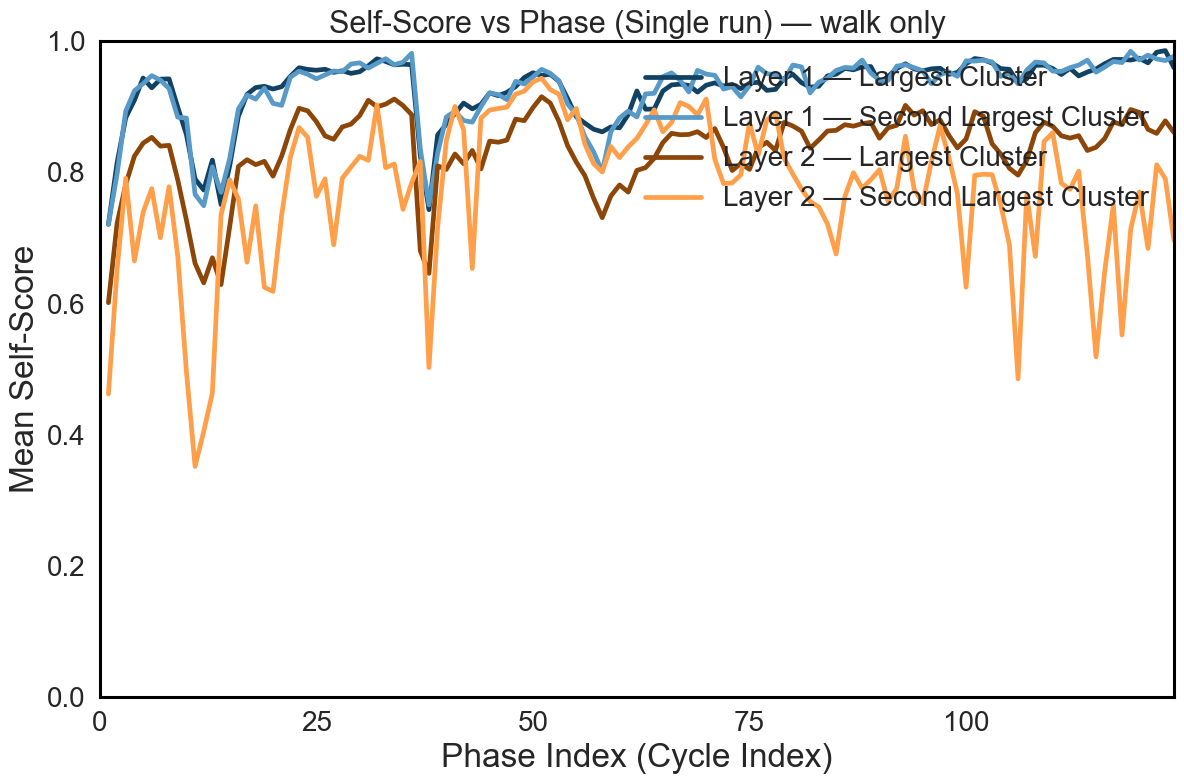

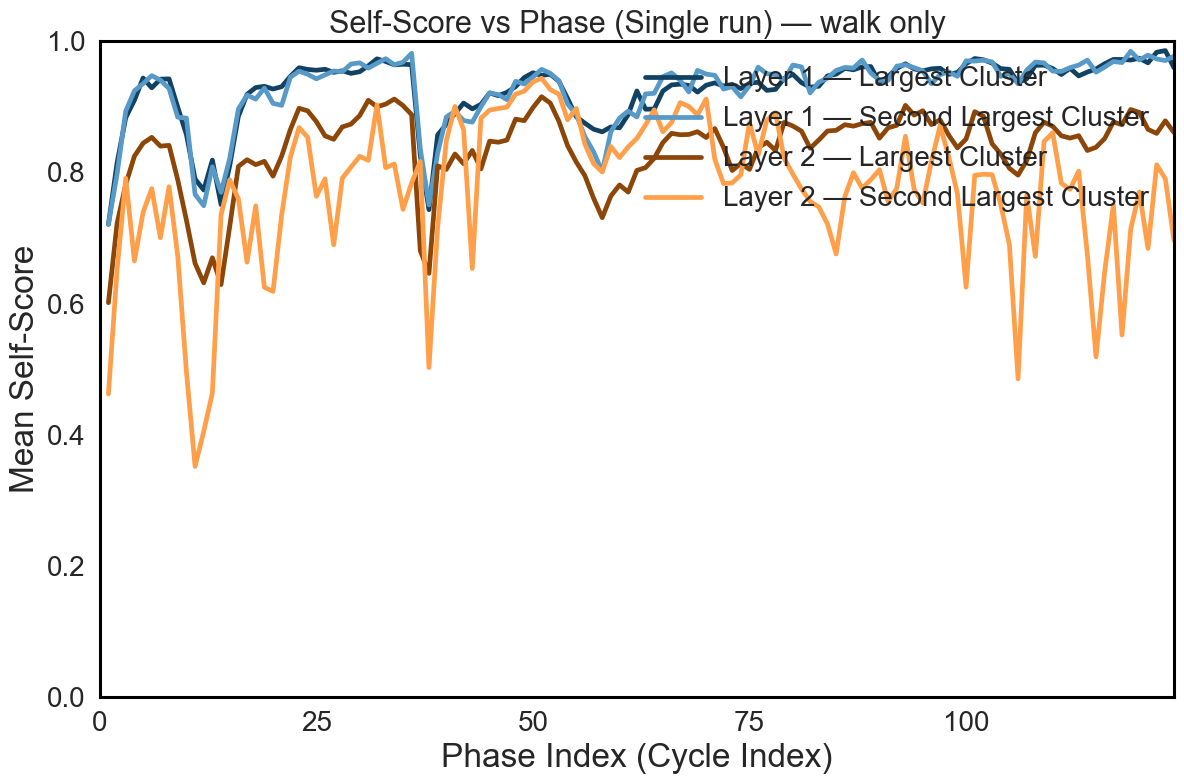

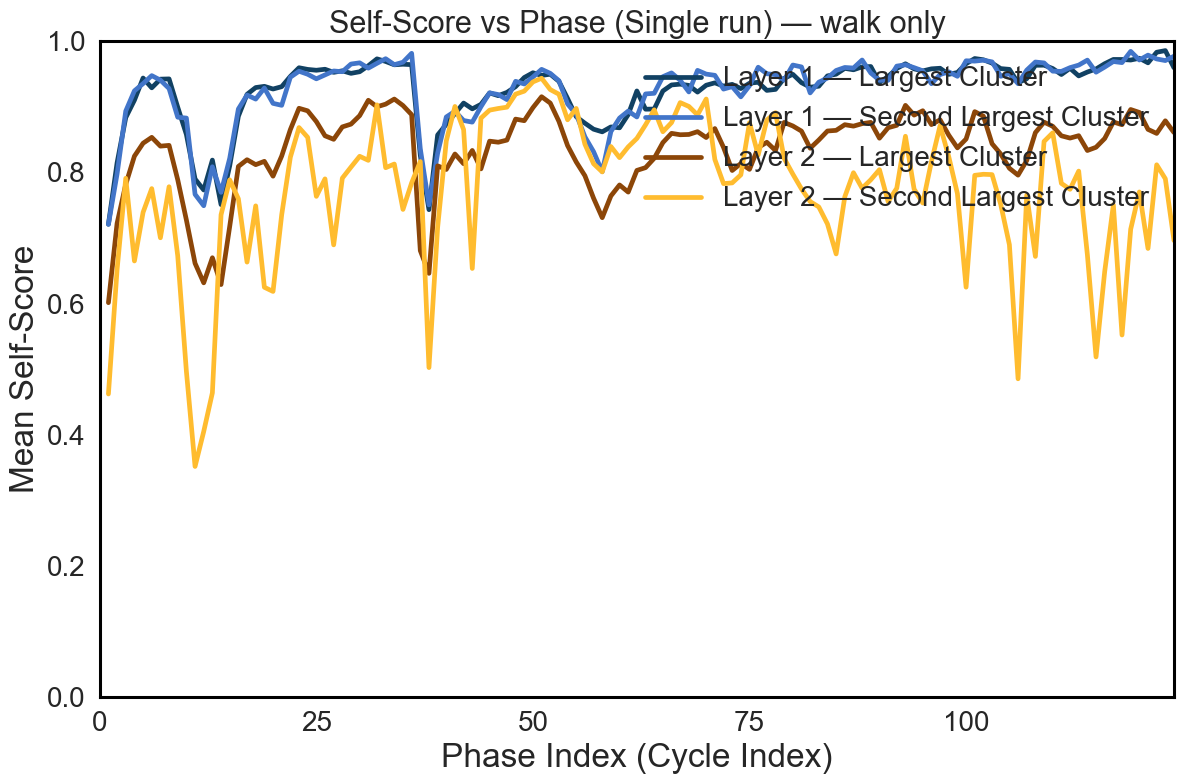

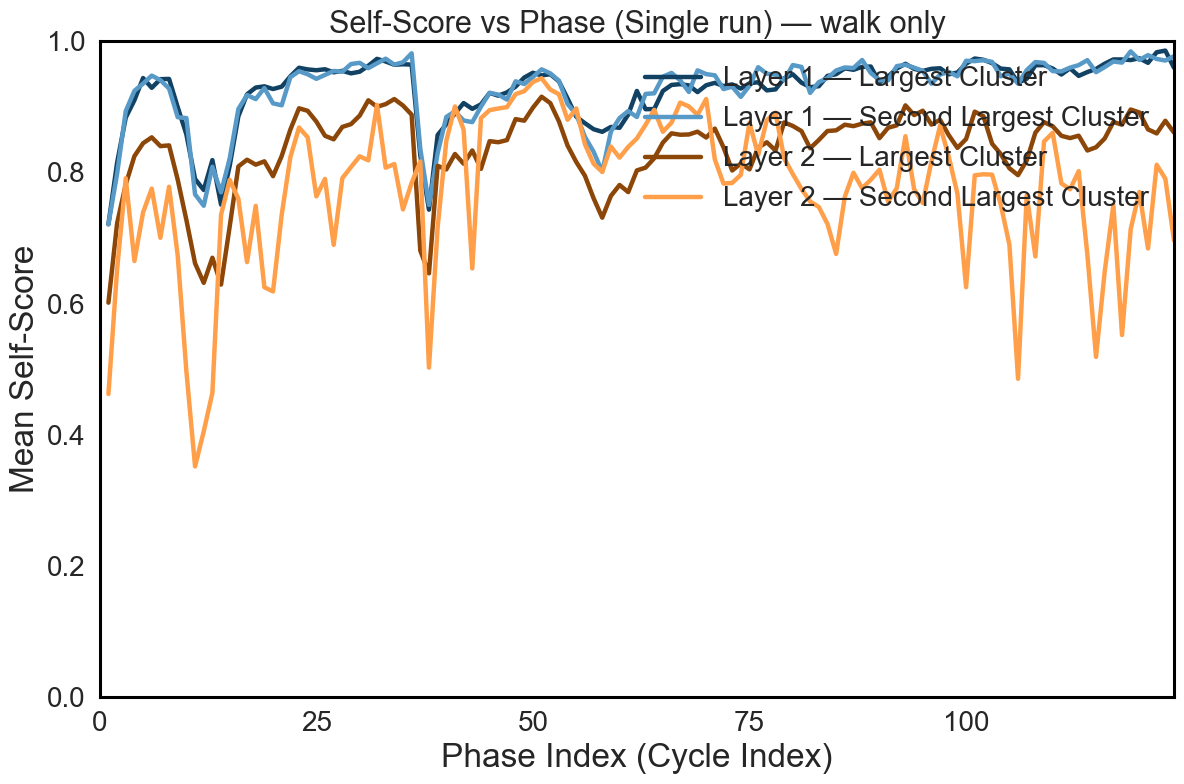

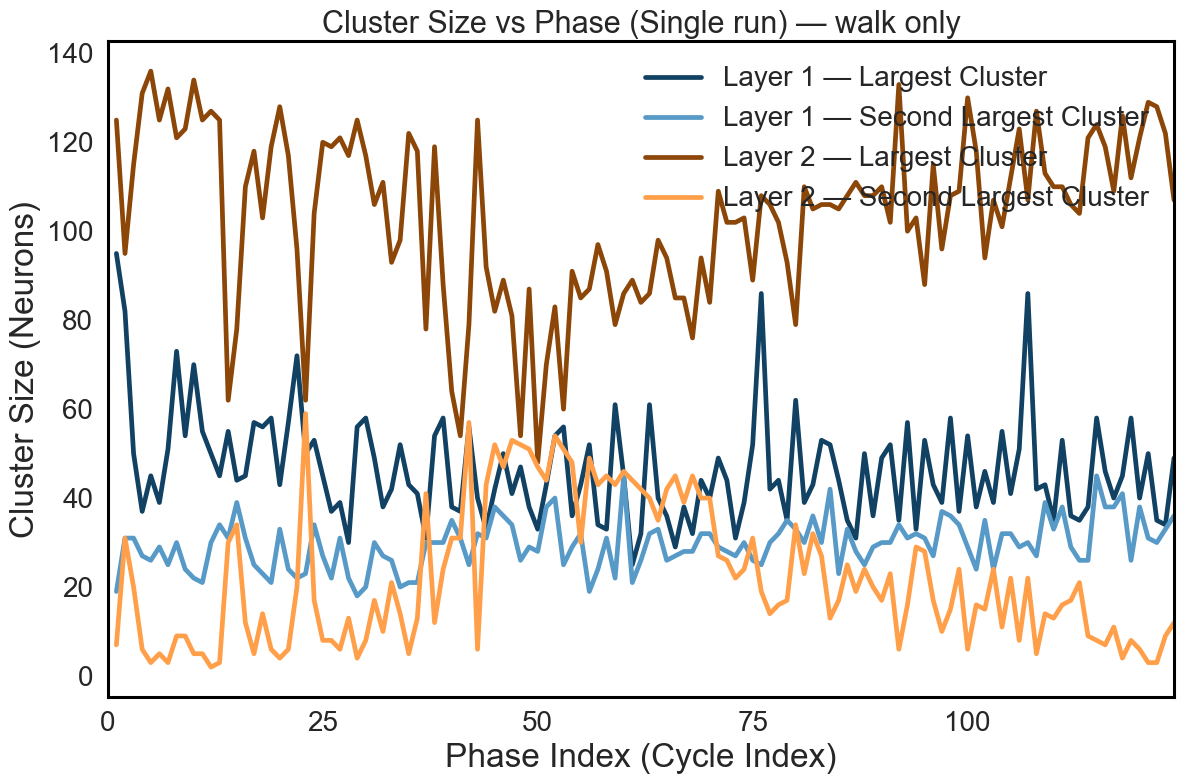

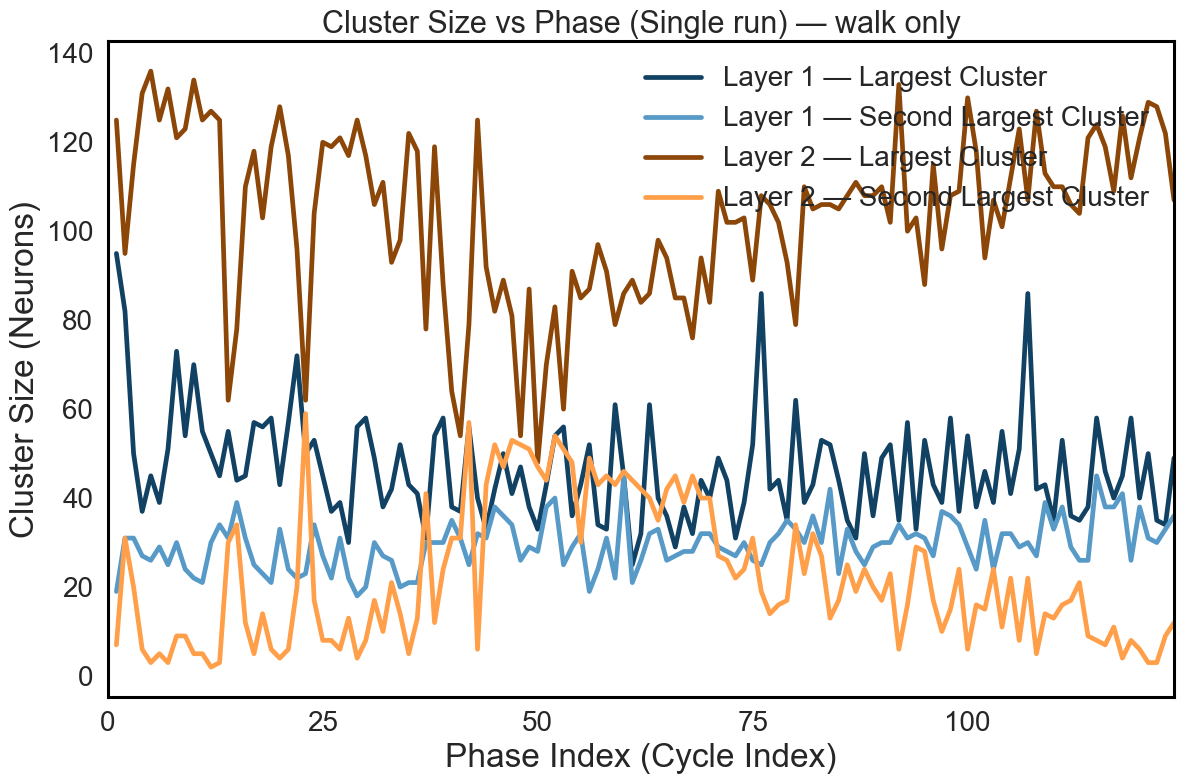

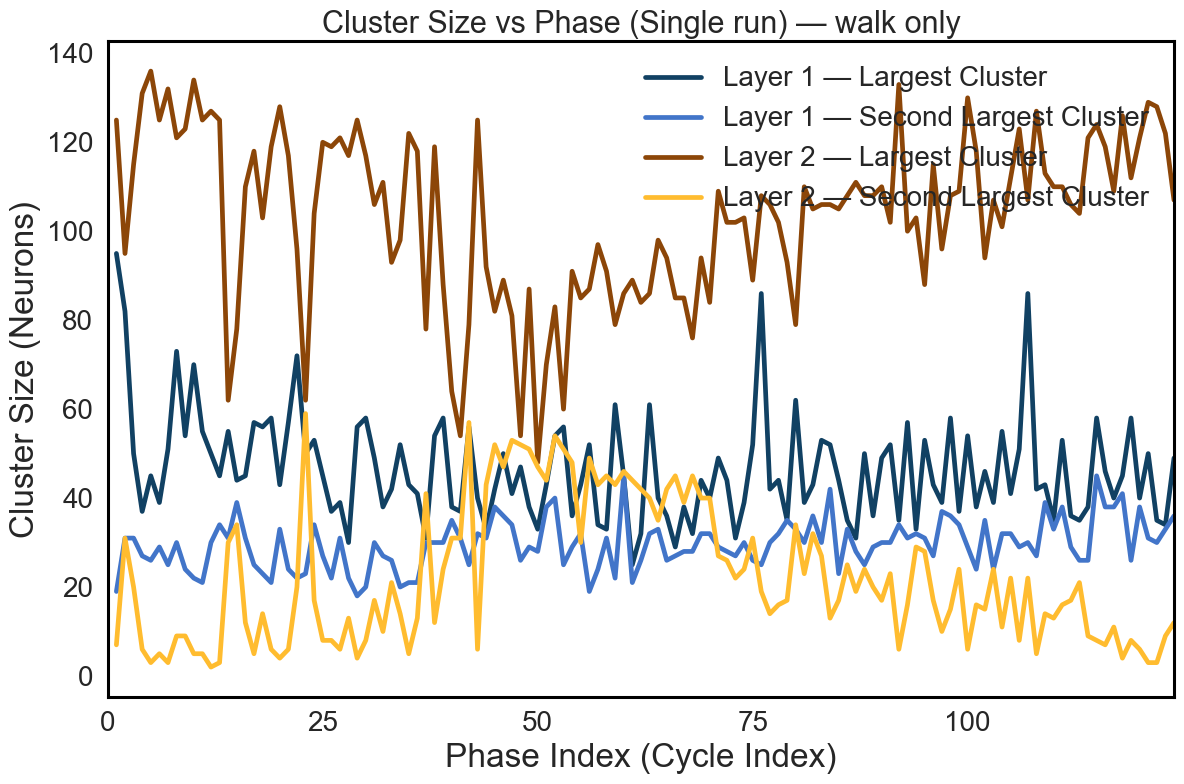

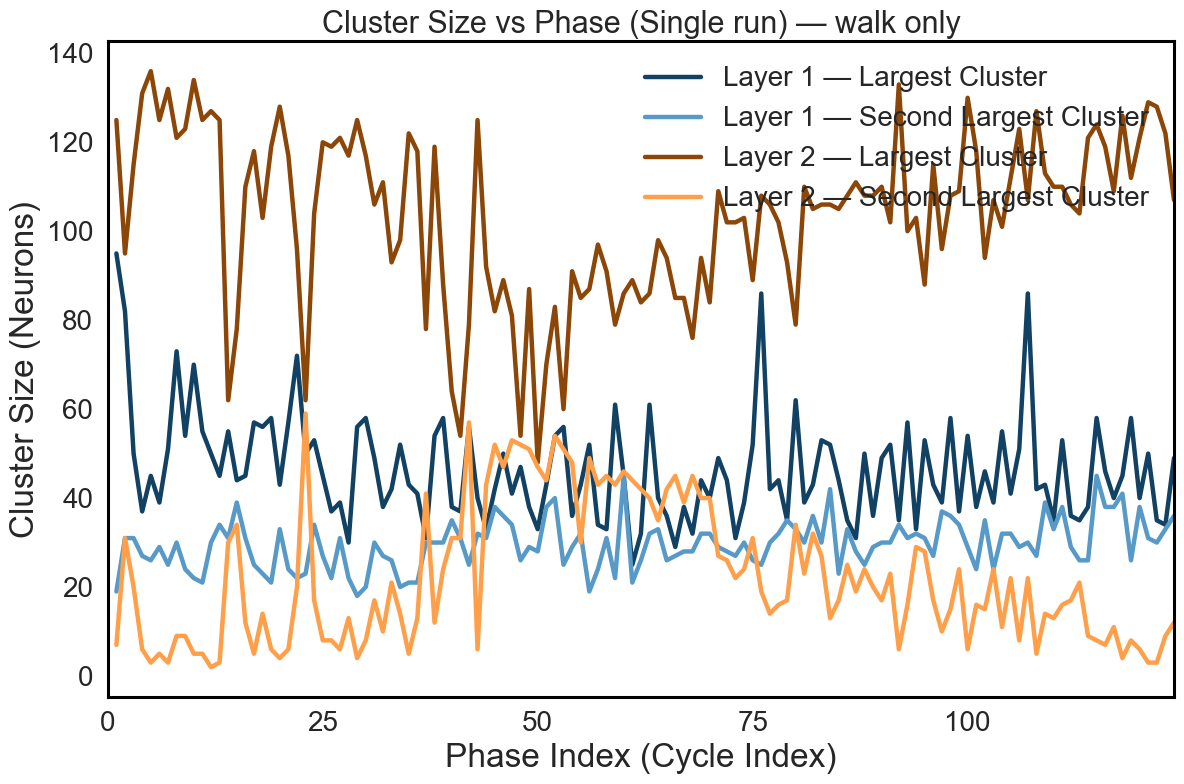

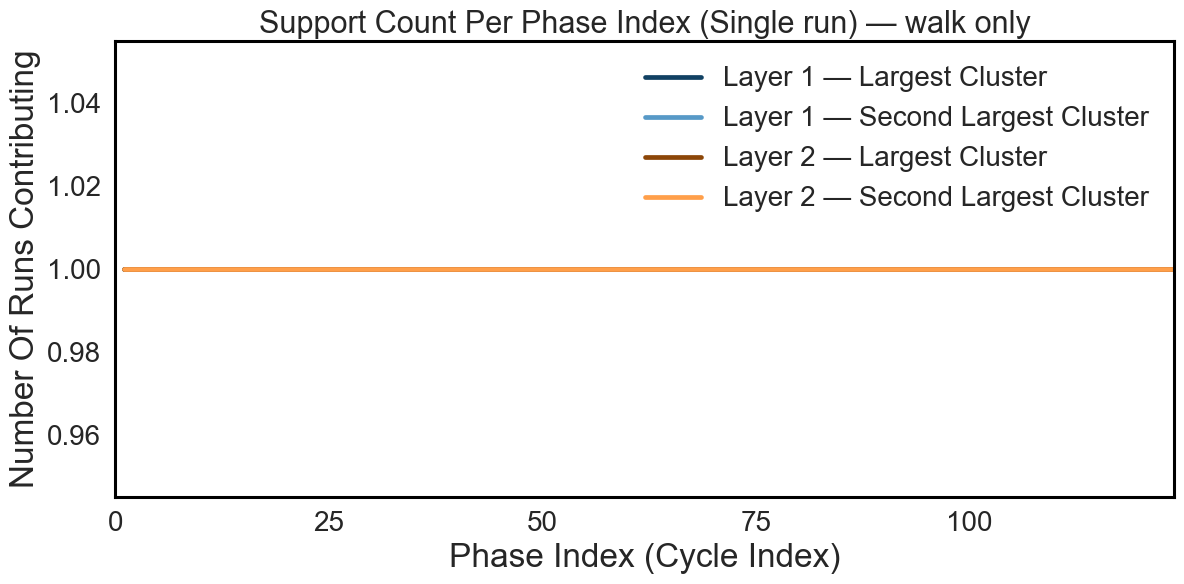

In [8]:
import os
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.errors import EmptyDataError
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl

# ============================================================
# =============== MULTI-RUN AGGREGATE PLOTTING ===============
#   ✅ now plots ALL phases present in the data by default
# ============================================================

# -------------------------
# CONFIG
# -------------------------
ROBUSTNESS_ROOT = "/Users/adi/Desktop/WSJ_att69_WalkOnly_relu_42_2026-02-01_03-48-47/"

SHOW_SPREAD_PLOTS = True

RANKS_TO_PLOT  = [1, 2]
LAYERS_TO_PLOT = None  # None -> auto-detect

# If you want to FORCE behaviors, set e.g. ["walk","jump","spin"] or ["walk"].
# Otherwise leave as "auto" and it will infer from the CSV(s).
BEHAVIORS = "auto"  # "auto" or list like ["walk","jump","spin"] or ["walk"]

Q_LOW  = 0.25
Q_HIGH = 0.75

# ✅ CHANGED: default is "use all cycles in the CSV(s)"
# Set to an int (e.g., 50) ONLY if you want to clamp.
N_CYCLES_PLANNED = None  # None -> no clamp; int -> clamp cycles to [0, N_CYCLES_PLANNED-1]

FIGSIZE_MAIN = (12, 8)
FIGSIZE_SUPPORT = (12, 6)

N_XTICKS_MAIN = 6

AXIS_LABEL_FONTSIZE = 24
TICK_LABEL_FONTSIZE = 20
TITLE_FONTSIZE = 22
LEGEND_FONTSIZE = 20

LINEWIDTH_MEAN = 3.4
LINEWIDTH_RUNS = 1.6
LINEWIDTH_ERROR_MEAN = 3.2

AXIS_SPINE_LINEWIDTH = 2.2
AXIS_SPINE_COLOR = "black"
TICK_WIDTH = 2.0
TICK_LENGTH = 7

mpl.rcParams["font.family"] = "Arial"
mpl.rcParams["font.sans-serif"] = ["Arial"]
sns.set_theme(style="white")
mpl.rcParams["axes.grid"] = False


# ============================================================
# Helpers
# ============================================================
def _find_phase_csvs(root: str):
    patterns = [
        os.path.join(root, "*", "models", "_module_explorer_cache", "phase_summary.csv"),
        os.path.join(root, "*", "organized", "models", "_module_explorer_cache", "phase_summary.csv"),
        os.path.join(root, "models", "_module_explorer_cache", "phase_summary.csv"),
        os.path.join(root, "organized", "models", "_module_explorer_cache", "phase_summary.csv"),
    ]
    out = []
    for pat in patterns:
        out.extend(glob.glob(pat))
    return sorted(set(out))


def _run_name_from_csv_path(csv_path: str) -> str:
    parts = os.path.normpath(csv_path).split(os.sep)
    root_base = os.path.basename(os.path.normpath(ROBUSTNESS_ROOT))
    try:
        idx = parts.index(root_base)
        return parts[idx + 1]
    except Exception:
        if "organized" in parts:
            return parts[parts.index("organized") - 1]
        if "models" in parts:
            return parts[parts.index("models") - 1]
        return os.path.basename(os.path.dirname(os.path.dirname(csv_path)))


def _safe_read_phase_csv(csv_path: str, min_bytes: int = 5):
    if not os.path.exists(csv_path):
        return None, "missing file"
    if os.path.getsize(csv_path) < min_bytes:
        return None, f"empty file (<{min_bytes} bytes)"
    try:
        df = pd.read_csv(csv_path)
    except EmptyDataError:
        return None, "EmptyDataError (no columns to parse)"
    except Exception as e:
        return None, f"read_csv failed: {type(e).__name__}: {e}"

    if df is None or df.shape[1] == 0:
        return None, "no columns after read"
    if len(df) == 0:
        return None, "valid header but 0 rows"

    required_cols = ["behavior", "layer_idx", "cluster_rank"]
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        return None, f"missing required cols: {missing}"

    return df, None


def _parse_cycle_num_from_cycle_id(cycle_id: str) -> int:
    m = re.search(r"(\d+)", str(cycle_id))
    return int(m.group(1)) if m else -1


def _ensure_cycle_num_column(df: pd.DataFrame) -> pd.DataFrame:
    if "cycle_num" in df.columns:
        out = df.copy()
        out["cycle_num"] = pd.to_numeric(out["cycle_num"], errors="coerce").fillna(-1).astype(int)
        return out
    if "cycle_idx" in df.columns:
        out = df.copy()
        out["cycle_num"] = pd.to_numeric(out["cycle_idx"], errors="coerce").fillna(-1).astype(int)
        return out
    if "cycle" in df.columns:
        out = df.copy()
        out["cycle_num"] = pd.to_numeric(out["cycle"], errors="coerce").fillna(-1).astype(int)
        return out
    if "cycle_id" in df.columns:
        out = df.copy()
        out["cycle_num"] = out["cycle_id"].apply(_parse_cycle_num_from_cycle_id).astype(int)
        return out
    if "step_idx" in df.columns:
        out = df.copy()
        step = pd.to_numeric(out["step_idx"], errors="coerce").fillna(-1).astype(int)
        out["cycle_num"] = step  # safe default for walk-only caches
        return out
    raise RuntimeError(
        "Could not determine cycle index. Expected one of: cycle_id / cycle_num / cycle_idx / cycle / step_idx."
    )


def _nanquantile_safe(x, q):
    arr = np.asarray(x, dtype=float)
    arr = arr[np.isfinite(arr)]
    if arr.size == 0:
        return np.nan
    return float(np.quantile(arr, q))


def _nanmin_safe(x):
    arr = np.asarray(x, dtype=float)
    arr = arr[np.isfinite(arr)]
    if arr.size == 0:
        return np.nan
    return float(np.min(arr))


def _nanmax_safe(x):
    arr = np.asarray(x, dtype=float)
    arr = arr[np.isfinite(arr)]
    if arr.size == 0:
        return np.nan
    return float(np.max(arr))


def _n_finite(x):
    arr = np.asarray(x, dtype=float)
    return int(np.sum(np.isfinite(arr)))


def _agg_combined_step(dfp, col: str, Q_LOW=0.25, Q_HIGH=0.75):
    gcols = ["step_abs", "layer_idx", "cluster_rank"]
    g = dfp.groupby(gcols)[col]
    out = g.agg(
        mean="mean",
        qlow=lambda x: _nanquantile_safe(x, Q_LOW),
        qhigh=lambda x: _nanquantile_safe(x, Q_HIGH),
        vmin=lambda x: _nanmin_safe(x),
        vmax=lambda x: _nanmax_safe(x),
        n=lambda x: _n_finite(x),
    ).reset_index()
    return out


def _make_dense_series_step(df_agg, layer_idx, rank, which="mean", max_step_abs=0):
    sub = df_agg[
        (df_agg["layer_idx"] == layer_idx) &
        (df_agg["cluster_rank"] == rank)
    ][["step_abs", which]].sort_values("step_abs")

    x = np.arange(max_step_abs + 1, dtype=int)
    y = np.full_like(x, np.nan, dtype=float)

    if len(sub) == 0:
        return x, y

    idx = sub["step_abs"].to_numpy(dtype=int)
    vals = sub[which].to_numpy(dtype=float)
    m = (idx >= 0) & (idx < len(y))
    y[idx[m]] = vals[m]
    return x, y


# ============================================================
# Colors
# ============================================================
_LAYER_BASE = sns.color_palette("tab10", n_colors=10)

def _blend(rgb, other_rgb, t):
    rgb = np.array(rgb, dtype=float)
    other_rgb = np.array(other_rgb, dtype=float)
    out = (1.0 - t) * rgb + t * other_rgb
    return tuple(np.clip(out, 0, 1))

def _darken(rgb, t=0.35):
    return _blend(rgb, (0, 0, 0), t)

def _lighten(rgb, t=0.35):
    return _blend(rgb, (1, 1, 1), t)

def _color_ab(rank, layer_color_index):
    base = _LAYER_BASE[layer_color_index % 10]
    if int(rank) == 1:
        return _darken(base, t=0.45)
    return _lighten(base, t=0.25)

def _color_c(rank, layer_color_index):
    base = np.array(_LAYER_BASE[layer_color_index % 10], dtype=float)
    hsv = rgb_to_hsv(base)
    if int(rank) == 1:
        return _darken(tuple(base), t=0.45)
    hsv2 = hsv.copy()
    hsv2[0] = (hsv2[0] + 0.035) % 1.0
    hsv2[1] = min(1.0, hsv2[1] * 1.05)
    hsv2[2] = min(1.0, hsv2[2] * 1.05)
    rgb2 = tuple(hsv_to_rgb(hsv2))
    return _lighten(rgb2, t=0.18)


# ============================================================
# Legend label rewrite
# ============================================================
def _layer_label(layer_idx: int) -> str:
    return f"Layer {int(layer_idx) + 1}"

def _rank_label(rank: int) -> str:
    r = int(rank)
    if r == 1:
        return "Largest Cluster"
    if r == 2:
        return "Second Largest Cluster"
    return f"Rank {r}"

def _legend_label(layer_idx: int, rank: int) -> str:
    return f"{_layer_label(layer_idx)} — {_rank_label(rank)}"


# ============================================================
# Paper-style axis formatting
# ============================================================
def _format_axes_paper(ax, xmin, xmax, n_xticks):
    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_linewidth(AXIS_SPINE_LINEWIDTH)
        spine.set_color(AXIS_SPINE_COLOR)

    ax.tick_params(axis="both", which="major",
                   labelsize=TICK_LABEL_FONTSIZE,
                   width=TICK_WIDTH, length=TICK_LENGTH,
                   color=AXIS_SPINE_COLOR)

    ax.margins(x=0)
    ax.set_xlim(xmin, xmax)
    try:
        ax.set_xbound(lower=xmin, upper=xmax)
    except Exception:
        pass
    ax.xaxis.set_major_locator(MaxNLocator(n_xticks, integer=True))

def _raise_title(ax):
    ax.title.set_y(1.03)


# ============================================================
# Load data
# ============================================================
phase_csvs = _find_phase_csvs(ROBUSTNESS_ROOT)
if not phase_csvs:
    raise FileNotFoundError(f"No phase_summary.csv found under: {ROBUSTNESS_ROOT}")

dfs = []
skipped = []
for csv_path in phase_csvs:
    run_name = _run_name_from_csv_path(csv_path)
    df, reason = _safe_read_phase_csv(csv_path)
    if df is None:
        skipped.append((run_name, csv_path, reason))
        continue

    df = df.copy()
    df["run_name"] = run_name
    try:
        df = _ensure_cycle_num_column(df)
    except Exception as e:
        skipped.append((run_name, csv_path, f"cycle inference failed: {type(e).__name__}: {e}"))
        continue

    dfs.append(df)

print(f"[INFO] Found {len(phase_csvs)} phase_summary.csv files")
print(f"[INFO] Loaded {len(dfs)} runs successfully")
print(f"[INFO] Skipped {len(skipped)} runs")

if skipped:
    print("\n[SKIPPED RUNS]")
    for rn, p, why in skipped:
        print(f"  - {rn}: {why}\n    {p}")

if not dfs:
    raise RuntimeError("No valid runs loaded (all phase_summary.csv were empty/invalid).")

df_all = pd.concat(dfs, ignore_index=True)

dfp = df_all.copy()
dfp["behavior"] = dfp["behavior"].astype(str).str.strip().str.lower()

# ---- infer behaviors if requested ----
_PREF_ORDER = ["walk", "jump", "spin"]
present = [b for b in _PREF_ORDER if b in set(dfp["behavior"].unique().tolist())]

if BEHAVIORS == "auto":
    if not present:
        present = sorted(set(dfp["behavior"].unique().tolist()))
        if not present:
            raise RuntimeError("No behaviors found in data.")
    BEH_USED = present
else:
    BEH_USED = [str(b).strip().lower() for b in list(BEHAVIORS)]
    BEH_USED = [b for b in BEH_USED if b in set(dfp["behavior"].unique().tolist())]
    if not BEH_USED:
        raise RuntimeError(f"Requested BEHAVIORS={BEHAVIORS} but none are present in the data.")

dfp = dfp[dfp["behavior"].isin(BEH_USED)].copy()

for c in ["layer_idx", "cluster_rank"]:
    dfp[c] = pd.to_numeric(dfp[c], errors="coerce").fillna(-1).astype(int)

dfp = dfp[dfp["cluster_rank"].isin(RANKS_TO_PLOT)].copy()

if LAYERS_TO_PLOT is None:
    layers_to_plot = sorted(dfp["layer_idx"].unique().tolist())
else:
    layers_to_plot = list(LAYERS_TO_PLOT)

if not layers_to_plot:
    raise RuntimeError("No layers found after loading all runs.")

# behavior index for absolute timeline
beh_to_idx = {b: i for i, b in enumerate(BEH_USED)}
dfp["beh_idx"] = dfp["behavior"].map(beh_to_idx).astype(int)

N_BEH_USED = len(BEH_USED)

# ✅ CHANGED: clamp only if you set N_CYCLES_PLANNED to an int
if N_CYCLES_PLANNED is not None:
    dfp = dfp[(dfp["cycle_num"] >= 0) & (dfp["cycle_num"] < int(N_CYCLES_PLANNED))].copy()
else:
    dfp = dfp[dfp["cycle_num"] >= 0].copy()

# absolute step
dfp["step_abs"] = dfp["cycle_num"] * N_BEH_USED + dfp["beh_idx"]

# ✅ CHANGED: plot range comes from data
if len(dfp) == 0:
    raise RuntimeError("No rows left after filtering; check cycle_num / behavior filters.")
MAX_STEP_ABS = int(dfp["step_abs"].max())

# drop incomplete cycles: require ALL behaviors in BEH_USED per (run, cycle, layer, rank)
grp = dfp.groupby(["run_name", "cycle_num", "layer_idx", "cluster_rank"])["behavior"].nunique()
valid_keys = grp[grp == N_BEH_USED].index
valid_df = valid_keys.to_frame(index=False)

dfp = dfp.merge(
    valid_df,
    on=["run_name", "cycle_num", "layer_idx", "cluster_rank"],
    how="inner"
).copy()

# recompute max after dropping incomplete cycles
if len(dfp) == 0:
    raise RuntimeError("All cycles dropped as incomplete; adjust BEHAVIORS or check the CSV content.")
MAX_STEP_ABS = int(dfp["step_abs"].max())

print(f"[INFO] Behaviors used: {BEH_USED}  (N_BEH_USED={N_BEH_USED})")
print(f"[INFO] Max phase index (MAX_STEP_ABS): {MAX_STEP_ABS}  -> phases plotted: {MAX_STEP_ABS + 1}")
print(f"[INFO] Rows after dropping incomplete cycles: {len(dfp)}")

n_runs_loaded = len(sorted(dfp["run_name"].unique().tolist()))
if n_runs_loaded <= 1:
    AVG_TAG = "(Single run)"
else:
    AVG_TAG = f"(Average across {n_runs_loaded} runs)"

if N_BEH_USED == 1:
    X_LABEL = "Phase Index (Cycle Index)"
    TITLE_SUFFIX = f"{AVG_TAG} — {BEH_USED[0]} only"
else:
    X_LABEL = "Phase Index Across Behaviors"
    TITLE_SUFFIX = f"{AVG_TAG} — behaviors: " + "/".join(BEH_USED)


# ============================================================
# Plots
# ============================================================
def _plot_combined_timeline(df_agg, col_name, ylabel, title, with_spread=False, ylim=None):
    plt.figure(figsize=FIGSIZE_MAIN)
    ax = plt.gca()

    for i, L in enumerate(layers_to_plot):
        for r in RANKS_TO_PLOT:
            color = _color_ab(r, i)
            x, y_mean = _make_dense_series_step(df_agg, L, r, which="mean", max_step_abs=MAX_STEP_ABS)
            m = np.isfinite(y_mean)
            if not np.any(m):
                continue

            ax.plot(x[m], y_mean[m], label=_legend_label(L, r),
                    color=color, alpha=1.0, linewidth=LINEWIDTH_MEAN)

            if with_spread:
                _, y_lo = _make_dense_series_step(df_agg, L, r, which="qlow", max_step_abs=MAX_STEP_ABS)
                _, y_hi = _make_dense_series_step(df_agg, L, r, which="qhigh", max_step_abs=MAX_STEP_ABS)
                m2 = np.isfinite(y_lo) & np.isfinite(y_hi)
                ax.fill_between(
                    x[m2], y_lo[m2], y_hi[m2],
                    color=color,
                    alpha=0.22 if int(r) == 1 else 0.16,
                    linewidth=0
                )

    ax.set_xlabel(X_LABEL, fontsize=AXIS_LABEL_FONTSIZE)
    ax.set_ylabel(ylabel, fontsize=AXIS_LABEL_FONTSIZE)
    ax.set_title(title, fontsize=TITLE_FONTSIZE)
    _raise_title(ax)
    if ylim is not None:
        ax.set_ylim(*ylim)

    _format_axes_paper(ax, 0, MAX_STEP_ABS, N_XTICKS_MAIN)
    ax.legend(fontsize=LEGEND_FONTSIZE, frameon=False, loc="upper right")
    plt.tight_layout()
    plt.show()


def _plot_combined_timeline_all_runs(df_agg, col_name, ylabel, title, ylim=None):
    plt.figure(figsize=FIGSIZE_MAIN)
    ax = plt.gca()

    run_names = sorted(dfp["run_name"].unique().tolist())
    run_alpha = 0.14
    mean_lw = LINEWIDTH_MEAN

    for i, L in enumerate(layers_to_plot):
        for r in RANKS_TO_PLOT:
            color = _color_c(r, i)

            for rn in run_names:
                sub = dfp[
                    (dfp["run_name"] == rn) &
                    (dfp["layer_idx"] == L) &
                    (dfp["cluster_rank"] == r)
                ][["step_abs", col_name]].sort_values("step_abs")

                if len(sub) == 0:
                    continue

                x = sub["step_abs"].to_numpy(dtype=int)
                y = sub[col_name].to_numpy(dtype=float)
                m = np.isfinite(x) & np.isfinite(y)
                if np.any(m):
                    ax.plot(x[m], y[m], color=color, alpha=run_alpha, linewidth=LINEWIDTH_RUNS)

            x, y_mean = _make_dense_series_step(df_agg, L, r, which="mean", max_step_abs=MAX_STEP_ABS)
            m = np.isfinite(y_mean)
            if np.any(m):
                ax.plot(x[m], y_mean[m], color=color, alpha=1.0, linewidth=mean_lw,
                        label=_legend_label(L, r))

    ax.set_xlabel(X_LABEL, fontsize=AXIS_LABEL_FONTSIZE)
    ax.set_ylabel(ylabel, fontsize=AXIS_LABEL_FONTSIZE)
    ax.set_title(title, fontsize=TITLE_FONTSIZE)
    _raise_title(ax)
    if ylim is not None:
        ax.set_ylim(*ylim)

    _format_axes_paper(ax, 0, MAX_STEP_ABS, N_XTICKS_MAIN)
    ax.legend(fontsize=LEGEND_FONTSIZE, frameon=False, loc="upper right")
    plt.tight_layout()
    plt.show()


def _plot_combined_timeline_errorbars(df_agg, col_name, ylabel, title, ylim=None):
    plt.figure(figsize=FIGSIZE_MAIN)
    ax = plt.gca()

    for i, L in enumerate(layers_to_plot):
        for r in RANKS_TO_PLOT:
            color = _color_ab(r, i)

            x, y_mean = _make_dense_series_step(df_agg, L, r, which="mean", max_step_abs=MAX_STEP_ABS)
            _, y_lo = _make_dense_series_step(df_agg, L, r, which="qlow", max_step_abs=MAX_STEP_ABS)
            _, y_hi = _make_dense_series_step(df_agg, L, r, which="qhigh", max_step_abs=MAX_STEP_ABS)
            _, y_min = _make_dense_series_step(df_agg, L, r, which="vmin", max_step_abs=MAX_STEP_ABS)
            _, y_max = _make_dense_series_step(df_agg, L, r, which="vmax", max_step_abs=MAX_STEP_ABS)

            m = np.isfinite(y_mean)
            if not np.any(m):
                continue

            ax.plot(x[m], y_mean[m], color=color, alpha=1.0,
                    linewidth=LINEWIDTH_ERROR_MEAN, label=_legend_label(L, r))

            m_iqr = m & np.isfinite(y_lo) & np.isfinite(y_hi)
            if np.any(m_iqr):
                lo = np.clip(y_mean[m_iqr] - y_lo[m_iqr], 0.0, np.inf)
                hi = np.clip(y_hi[m_iqr] - y_mean[m_iqr], 0.0, np.inf)
                ax.errorbar(
                    x[m_iqr], y_mean[m_iqr],
                    yerr=[lo, hi],
                    fmt="none",
                    ecolor=color,
                    elinewidth=1.8,
                    capsize=0,
                    alpha=0.60,
                    zorder=1
                )

            m_rng = m & np.isfinite(y_min) & np.isfinite(y_max)
            if np.any(m_rng):
                lo = np.clip(y_mean[m_rng] - y_min[m_rng], 0.0, np.inf)
                hi = np.clip(y_max[m_rng] - y_mean[m_rng], 0.0, np.inf)
                ax.errorbar(
                    x[m_rng], y_mean[m_rng],
                    yerr=[lo, hi],
                    fmt="none",
                    ecolor=color,
                    elinewidth=1.1,
                    capsize=0,
                    alpha=0.28,
                    zorder=0
                )

    ax.set_xlabel(X_LABEL, fontsize=AXIS_LABEL_FONTSIZE)
    ax.set_ylabel(ylabel, fontsize=AXIS_LABEL_FONTSIZE)
    ax.set_title(title, fontsize=TITLE_FONTSIZE)
    _raise_title(ax)
    if ylim is not None:
        ax.set_ylim(*ylim)

    _format_axes_paper(ax, 0, MAX_STEP_ABS, N_XTICKS_MAIN)
    ax.legend(fontsize=LEGEND_FONTSIZE, frameon=False, loc="upper right")
    plt.tight_layout()
    plt.show()


def _plot_support_counts(df_agg_counts, title):
    plt.figure(figsize=FIGSIZE_SUPPORT)
    ax = plt.gca()

    for i, L in enumerate(layers_to_plot):
        for r in RANKS_TO_PLOT:
            color = _color_ab(r, i)
            x, y = _make_dense_series_step(df_agg_counts, L, r, which="n", max_step_abs=MAX_STEP_ABS)
            m = np.isfinite(y)
            if not np.any(m):
                continue

            ax.plot(x[m], y[m], color=color, alpha=1.0,
                    linewidth=LINEWIDTH_MEAN, label=_legend_label(L, r))

    ax.set_xlabel(X_LABEL, fontsize=AXIS_LABEL_FONTSIZE)
    ax.set_ylabel("Number Of Runs Contributing", fontsize=AXIS_LABEL_FONTSIZE)
    ax.set_title(title, fontsize=TITLE_FONTSIZE)
    _raise_title(ax)

    _format_axes_paper(ax, 0, MAX_STEP_ABS, N_XTICKS_MAIN)
    ax.legend(fontsize=LEGEND_FONTSIZE, frameon=False, loc="upper right")
    plt.tight_layout()
    plt.show()
# ---- column compat: self-score vs persistence-score ----
if "mean_self_score" not in dfp.columns:
    if "mean_persistence_score" in dfp.columns:
        dfp["mean_self_score"] = pd.to_numeric(dfp["mean_persistence_score"], errors="coerce")
    elif "mean_persistence" in dfp.columns:
        dfp["mean_self_score"] = pd.to_numeric(dfp["mean_persistence"], errors="coerce")
    else:
        raise KeyError(
            "Missing score column. Expected one of: mean_self_score / mean_persistence_score."
        )


# ============================================================
# Run plots
# ============================================================
df_self_step = _agg_combined_step(dfp, "mean_self_score", Q_LOW=Q_LOW, Q_HIGH=Q_HIGH)
_plot_combined_timeline(df_self_step, "mean_self_score", "Mean Self-Score",
                        f"Self-Score vs Phase {TITLE_SUFFIX}",
                        with_spread=False, ylim=(0, 1))

if SHOW_SPREAD_PLOTS:
    _plot_combined_timeline(df_self_step, "mean_self_score", "Mean Self-Score",
                            f"Self-Score vs Phase {TITLE_SUFFIX}",
                            with_spread=True, ylim=(0, 1))

_plot_combined_timeline_all_runs(df_self_step, "mean_self_score", "Mean Self-Score",
                                 f"Self-Score vs Phase {TITLE_SUFFIX}",
                                 ylim=(0, 1))

_plot_combined_timeline_errorbars(df_self_step, "mean_self_score", "Mean Self-Score",
                                  f"Self-Score vs Phase {TITLE_SUFFIX}",
                                  ylim=(0, 1))

df_size_step = _agg_combined_step(dfp, "cluster_size_neurons", Q_LOW=Q_LOW, Q_HIGH=Q_HIGH)
_plot_combined_timeline(df_size_step, "cluster_size_neurons", "Cluster Size (Neurons)",
                        f"Cluster Size vs Phase {TITLE_SUFFIX}",
                        with_spread=False, ylim=None)

if SHOW_SPREAD_PLOTS:
    _plot_combined_timeline(df_size_step, "cluster_size_neurons", "Cluster Size (Neurons)",
                            f"Cluster Size vs Phase {TITLE_SUFFIX}",
                            with_spread=True, ylim=None)

_plot_combined_timeline_all_runs(df_size_step, "cluster_size_neurons", "Cluster Size (Neurons)",
                                 f"Cluster Size vs Phase {TITLE_SUFFIX}",
                                 ylim=None)

_plot_combined_timeline_errorbars(df_size_step, "cluster_size_neurons", "Cluster Size (Neurons)",
                                  f"Cluster Size vs Phase {TITLE_SUFFIX}",
                                  ylim=None)

_plot_support_counts(df_self_step, f"Support Count Per Phase Index {TITLE_SUFFIX}")
